In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve

In [2]:
#df=pd.read_excel('VAE1817_BSEV_F_Young3.xlsx')
df=pd.read_excel('VAE1718_NoOutliers_BSEV_F_Young1.xlsx')

In [3]:
df.head()

AGE_YRS  NUMDAYS  VAX_DOSE_SERIES  M/F  BIRTHDEF_Y/N  NUM_SYMPS  SYMP_SEV  \
0     35.0       18                1    1             0          2  2.000000   
1     52.0        3                2    1             0          1  0.000000   
2     11.0       52                1    1             0          2  0.000000   
3     16.0        0                1    0             0          3  1.333333   
4     11.0        0                1    0             0          2  0.000000   

   MEDS_Y/N  CILL_Y/N  HIST_Y/N    ...     AR  GM  LA  LG  LL  MO  NS  RA  RL  \
0         0         0         0    ...      0   0   0   0   0   0   0   1   0   
1         0         0         1    ...      0   0   0   0   0   0   0   1   0   
2         0         0         0    ...      0   0   1   0   0   0   0   0   0   
3         1         1         1    ...      0   0   0   0   0   0   0   1   0   
4         1         0         0    ...      0   0   1   0   0   0   0   0   0   

   SEVERITY  
0         1  
1         1  
2         1  
3         1  
4         0  

[5 rows x 107 columns]

In [14]:
# Data Splitting
labels = df['SEVERITY']
data=df.drop('SEVERITY',axis=1)
#First Testing Non-stratified|
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state= 1409)
#Using Built in stratification
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(data, labels, test_size=0.25,stratify=labels, random_state=1409)
#Manually Undersampling
from imblearn.under_sampling import RandomUnderSampler
X_res, y_res = RandomUnderSampler(random_state=654).fit_sample(data, labels)
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_res, y_res, test_size=0.25, random_state=1994)
X_train_us_str, X_test_us_str, y_train_us_str, y_test_us_str = train_test_split(X_res, y_res, test_size=0.25, stratify=y_res, random_state=1994)

The optimal penalty is l1.
The optimal C is:  1.111522779009386


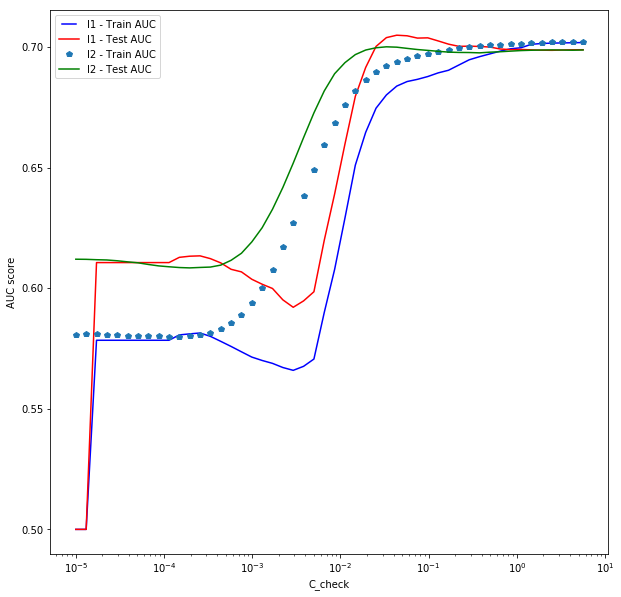

In [5]:
## Logistic Regression Tuning with NO Class Balancing
# done by looping twice, for both penalty's and various C values for each
# this code is identical for the next several blocks - all that changes is the method of data balancing
# and some variables in order to stores the optimal results
from sklearn.linear_model import LogisticRegression
from matplotlib.legend_handler import HandlerLine2D
# Create logistic regression
lr = LogisticRegression(solver = 'liblinear')
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create C value logspace
C = np.logspace(-5, 0.75, 50)

train_results = []
test_results = []
plt.figure(figsize=(10,10))
for pen_check in penalty:
    #storing results from previous run for comparison later
    l1_tr=test_results
    l1_train=train_results
    train_results = []
    test_results = []
    for C_check in C:
        lr = LogisticRegression(solver = 'liblinear',C=C_check,penalty=pen_check)
        lr.fit(X_train, y_train)

        train_pred = lr.predict_proba(X_train)[:,1]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)

        y_pred = lr.predict_proba(X_test)[:,1]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)


    if pen_check=='l1':
        line1, = plt.plot(C, train_results, 'b', label="l1 - Train AUC")
        line2, = plt.plot(C, test_results, 'r', label="l1 - Test AUC")
    elif pen_check == 'l2':
        line3, = plt.plot(C, train_results, 'p', label="l2 - Train AUC")
        line4, = plt.plot(C, test_results, 'g', label="l2 - Test AUC")
# Looping through results to cancel out pairs that overfit or where test>train 
for i in range(len(l1_tr)):
        if abs(l1_tr[i]-l1_train[i])>0.04 or l1_tr[i]>l1_train[i]:
            l1_tr[i]=0
        if abs(train_results[i]-test_results[i])>0.04 or train_results[i]<test_results[i]:
            test_results[i]=0
if max(l1_tr)>max(test_results):
    index=np.argmax(l1_tr)
    lr_pen_nb='l1'
    lr_c_nb=C[index]
    lr_auc_nb=l1_tr[index]
    print('The optimal penalty is l1.')
    print('The optimal C is: ',C[index])
else:
    index=np.argmax(test_results)
    lr_pen_bn='l2'
    lr_c_nb=C[index]
    lr_auc_nb=test_results[index]
    print('The optimal penalty is l2.')
    print('The optimal C is: ',C[index])
    
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xscale('log')
plt.xlabel('C_check')
#plt.xlim(0,200)
plt.show()

The optimal penalty is l1.
The optimal C is:  0.647477214675306


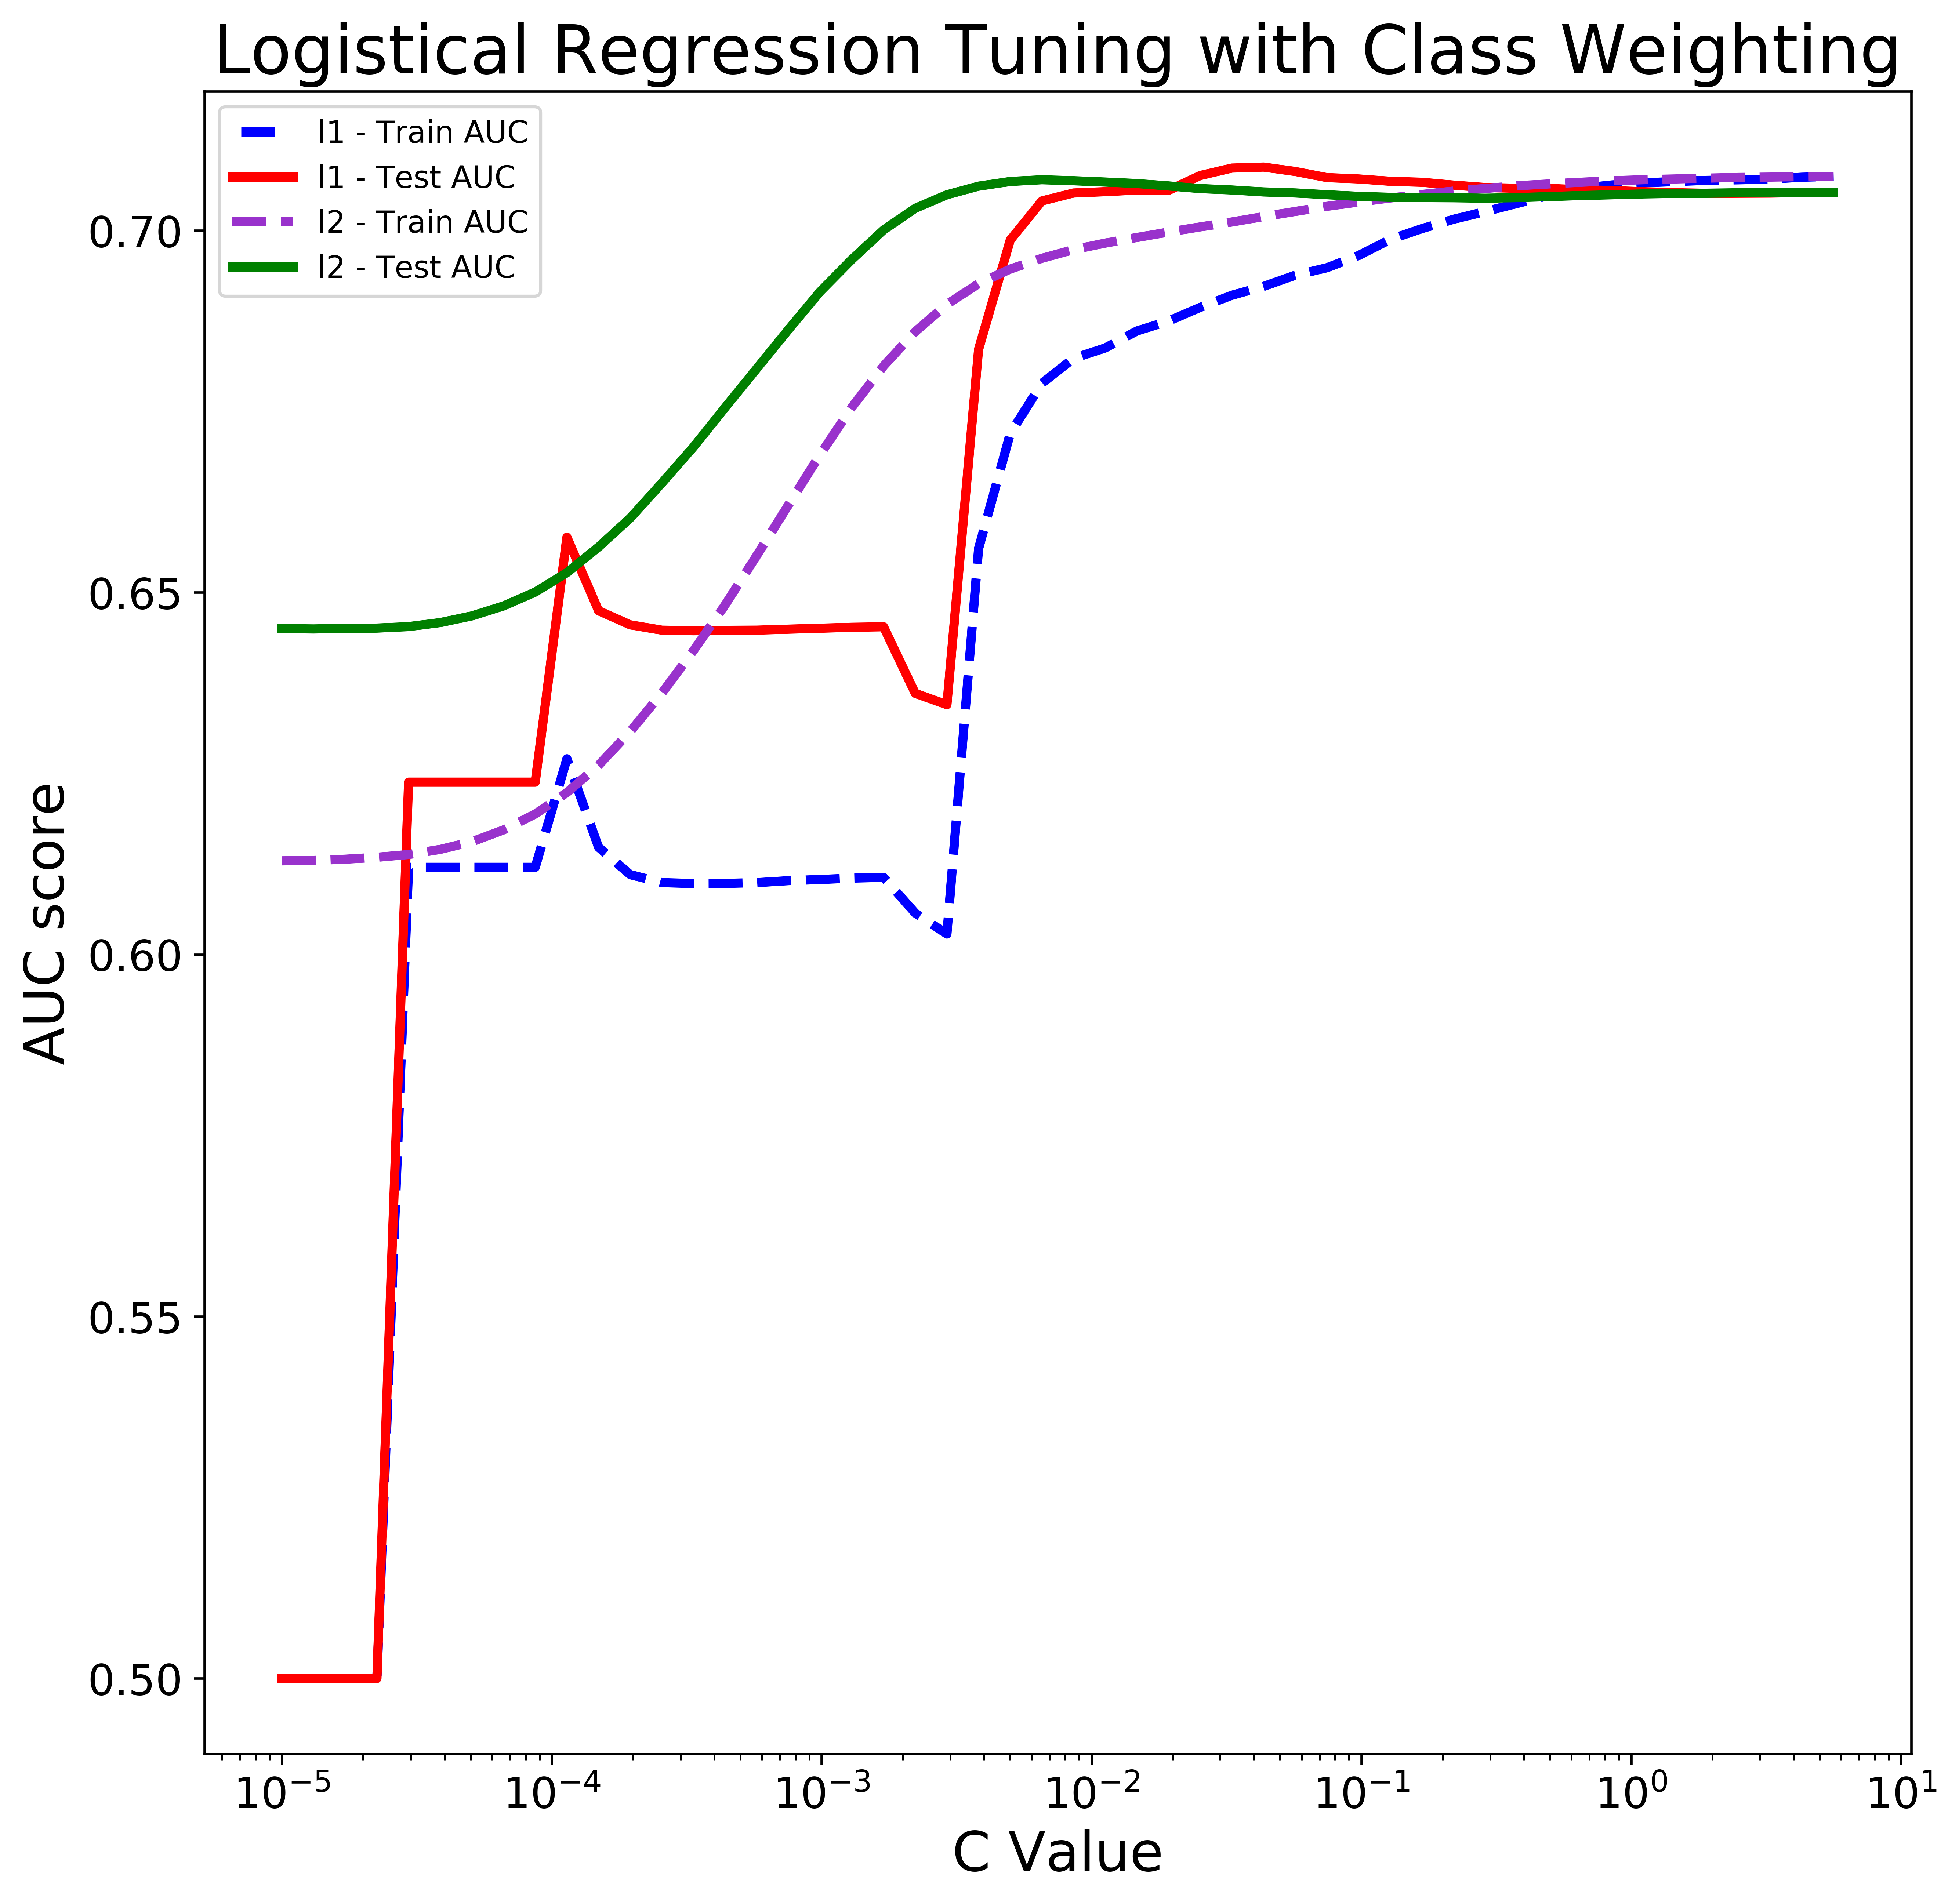

In [55]:
## Logistic Regression Tuning with model Class Balancing
# done by looping twice, for both penalty's and various C values for each
from sklearn.linear_model import LogisticRegression
from matplotlib.legend_handler import HandlerLine2D
# Create logistic regression
lr = LogisticRegression(solver = 'liblinear')
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create C hyperparameter space
C = np.logspace(-5, 0.75, 50)
train_results = []
test_results = []
plt.figure(figsize=(10,10),dpi=600)
for pen_check in penalty:
    #storing results from previous run for comparison later
    l1_tr=test_results
    l1_train=train_results
    train_results = []
    test_results = []
    for C_check in C:
        lr = LogisticRegression(solver = 'liblinear',C=C_check,penalty=pen_check,class_weight='balanced')
        lr.fit(X_train, y_train)

        train_pred = lr.predict_proba(X_train)[:,1]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)

        y_pred = lr.predict_proba(X_test)[:,1]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)


    if pen_check=='l1':
        line1, = plt.plot(C, train_results, 'b', label="l1 - Train AUC",linewidth=3,linestyle='--')
        line2, = plt.plot(C, test_results, 'r', label="l1 - Test AUC",linewidth=3)
    elif pen_check == 'l2':
        line3, = plt.plot(C, train_results, 'darkorchid', label="l2 - Train AUC",linewidth=3,linestyle='--')
        line4, = plt.plot(C, test_results, 'g', label="l2 - Test AUC",linewidth=3)
    
# Looping through results to cancel out pairs that overfit or where test>train
for i in range(len(l1_tr)):
        if abs(l1_tr[i]-l1_train[i])>0.04 or l1_tr[i]>l1_train[i]:
            l1_tr[i]=0
        if abs(train_results[i]-test_results[i])>0.04 or train_results[i]<test_results[i]:
            test_results[i]=0
#obtain parameters that yield the highest AUC-ROC score
if max(l1_tr)>max(test_results):
    index=np.argmax(l1_tr)
    lr_pen_cw='l1'
    lr_c_cw=C[index]
    lr_auc_cw=l1_tr[index]
    print('The optimal penalty is l1.')
    print('The optimal C is: ',C[index])
else:
    index=np.argmax(test_results)
    lr_pen_cw='l2'
    lr_c_cw=C[index]
    lr_auc_cw=test_results[index]
    print('The optimal penalty is l2.')
    print('The optimal C is: ',C[index])
    
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score',fontsize=18)
plt.xscale('log')
plt.title('Logistical Regression Tuning with Class Weighting', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('C Value', fontsize=18)
#plt.xlim(0,200)
plt.savefig('LR Tuning.png')
plt.show()

The optimal penalty is l1.
The optimal C is:  0.07455022861458495


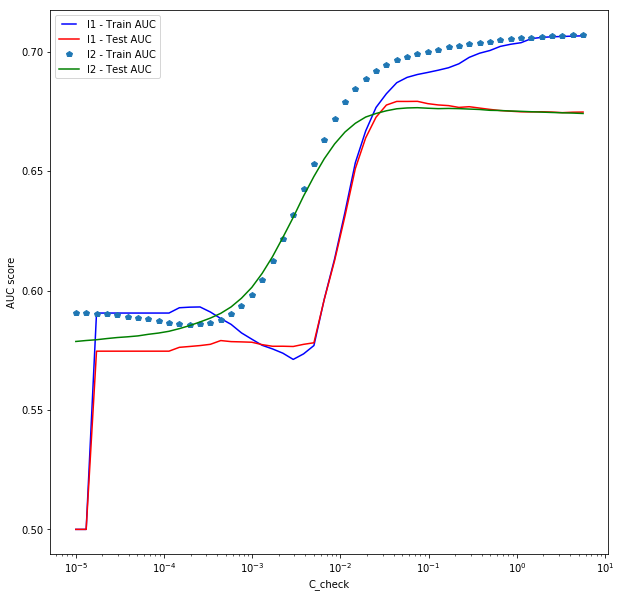

In [7]:
## Logistic Regression Tuning with stratification
from sklearn.linear_model import LogisticRegression
from matplotlib.legend_handler import HandlerLine2D
# Create logistic regression
lr = LogisticRegression(solver = 'liblinear')
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(-5, 0.75, 50)

train_results = []
test_results = []
plt.figure(figsize=(10,10))
for pen_check in penalty:
    l1_train=train_results
    l1_tr=test_results
    train_results = []
    test_results = []
    for C_check in C:
        lr = LogisticRegression(solver = 'liblinear',C=C_check,penalty=pen_check)
        lr.fit(X_train_strat, y_train_strat)

        train_pred = lr.predict_proba(X_train_strat)[:,1]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_strat, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)

        y_pred = lr.predict_proba(X_test_strat)[:,1]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_strat, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)


    if pen_check=='l1':
        line1, = plt.plot(C, train_results, 'b', label="l1 - Train AUC")
        line2, = plt.plot(C, test_results, 'r', label="l1 - Test AUC")
    elif pen_check == 'l2':
        line3, = plt.plot(C, train_results, 'p', label="l2 - Train AUC")
        line4, = plt.plot(C, test_results, 'g', label="l2 - Test AUC")
    
for i in range(len(l1_tr)):
        if abs(l1_tr[i]-l1_train[i])>0.04 or l1_tr[i]>l1_train[i]:
            l1_tr[i]=0
        if abs(train_results[i]-test_results[i])>0.04 or train_results[i]<test_results[i]:
            test_results[i]=0
if max(l1_tr)>max(test_results):
    index=np.argmax(l1_tr)
    lr_pen_str='l1'
    lr_c_str=C[index]
    lr_auc_str=l1_tr[index]
    print('The optimal penalty is l1.')
    print('The optimal C is: ',C[index])
else:
    index=np.argmax(test_results)
    lr_pen_str='l2'
    lr_c_str=C[index]
    lr_auc_str=test_results[index]
    print('The optimal penalty is l2.')
    print('The optimal C is: ',C[index])

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xscale('log')
plt.xlabel('C_check')
#plt.xlim(0,200)
plt.show()

The optimal penalty is l1.
The optimal C is:  0.21970337816423946


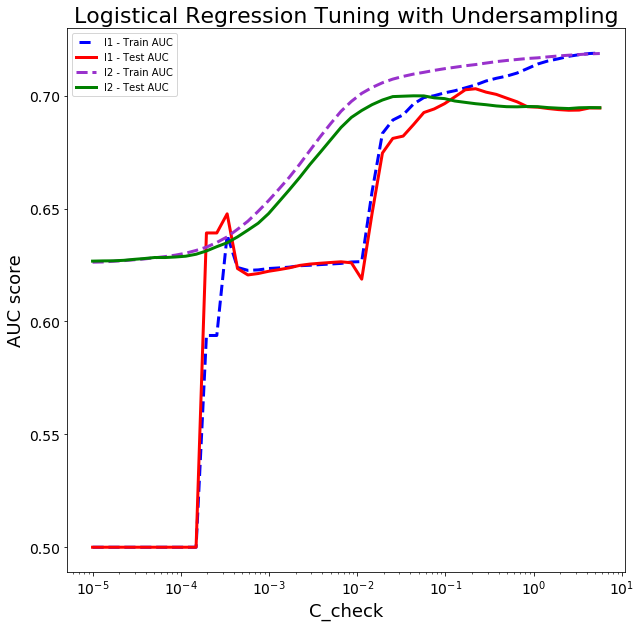

In [11]:
## Logistic Regression Tuning with undersampling Class Balancing
from sklearn.linear_model import LogisticRegression
from matplotlib.legend_handler import HandlerLine2D
# Create logistic regression
lr = LogisticRegression(solver = 'liblinear')
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(-5, 0.75, 50)

train_results = []
test_results = []
plt.figure(figsize=(10,10))
for pen_check in penalty:
    l1_train=train_results
    l1_tr=test_results
    train_results = []
    test_results = []
    for C_check in C:
        lr = LogisticRegression(solver = 'liblinear',C=C_check,penalty=pen_check)
        lr.fit(X_train_us, y_train_us)

        train_pred = lr.predict_proba(X_train_us)[:,1]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_us, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)

        y_pred = lr.predict_proba(X_test_us)[:,1]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_us, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)


    if pen_check=='l1':
        line1, = plt.plot(C, train_results, 'b', label="l1 - Train AUC",linewidth=3,linestyle='--')
        line2, = plt.plot(C, test_results, 'r', label="l1 - Test AUC",linewidth=3)
    elif pen_check == 'l2':
        line3, = plt.plot(C, train_results, 'darkorchid', label="l2 - Train AUC",linewidth=3,linestyle='--')
        line4, = plt.plot(C, test_results, 'g', label="l2 - Test AUC",linewidth=3)
    

for i in range(len(l1_tr)):
        if abs(l1_tr[i]-l1_train[i])>0.04 or l1_tr[i]>l1_train[i]:
            l1_tr[i]=0
        if abs(train_results[i]-test_results[i])>0.04 or train_results[i]<test_results[i]:
            test_results[i]=0
if max(l1_tr)>max(test_results):
    index=np.argmax(l1_tr)
    lr_pen_us='l1'
    lr_c_us=C[index]
    lr_auc_us=l1_tr[index]
    print('The optimal penalty is l1.')
    print('The optimal C is: ',C[index])
else:
    index=np.argmax(test_results)
    lr_pen_us='l2'
    lr_c_us=C[index]
    lr_auc_us=test_results[index]
    print('The optimal penalty is l2.')
    print('The optimal C is: ',C[index])

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score',fontsize=18)
plt.xscale('log')
plt.title('Logistical Regression Tuning with Undersampling', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('C_check', fontsize=18)
#plt.xlim(0,200)
plt.savefig('LR Tuning.png')
plt.show()

The optimal penalty is l1.
The optimal C is:  0.21970337816423946


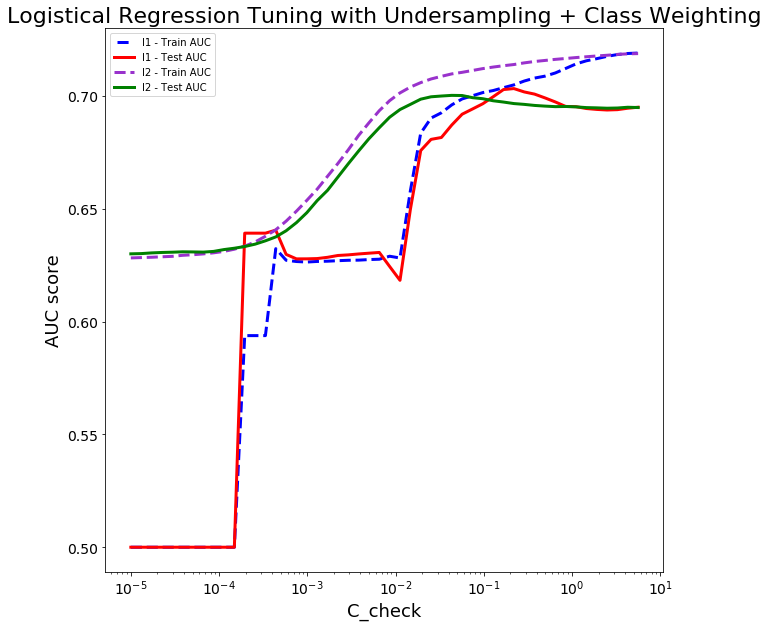

In [12]:
## Logistic Regression Tuning with undersampling + class weighting Class Balancing
from sklearn.linear_model import LogisticRegression
from matplotlib.legend_handler import HandlerLine2D
# Create logistic regression
lr = LogisticRegression(solver = 'liblinear')
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(-5, 0.75, 50)

train_results = []
test_results = []
plt.figure(figsize=(10,10))
for pen_check in penalty:
    l1_train=train_results
    l1_tr=test_results
    train_results = []
    test_results = []
    for C_check in C:
        lr = LogisticRegression(solver = 'liblinear',class_weight='balanced',C=C_check,penalty=pen_check)
        lr.fit(X_train_us, y_train_us)

        train_pred = lr.predict_proba(X_train_us)[:,1]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_us, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)

        y_pred = lr.predict_proba(X_test_us)[:,1]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_us, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)


    if pen_check=='l1':
        line1, = plt.plot(C, train_results, 'b', label="l1 - Train AUC",linewidth=3,linestyle='--')
        line2, = plt.plot(C, test_results, 'r', label="l1 - Test AUC",linewidth=3)
    elif pen_check == 'l2':
        line3, = plt.plot(C, train_results, 'darkorchid', label="l2 - Train AUC",linewidth=3,linestyle='--')
        line4, = plt.plot(C, test_results, 'g', label="l2 - Test AUC",linewidth=3)
    

for i in range(len(l1_tr)):
        if abs(l1_tr[i]-l1_train[i])>0.04 or l1_tr[i]>l1_train[i]:
            l1_tr[i]=0
        if abs(train_results[i]-test_results[i])>0.04 or train_results[i]<test_results[i]:
            test_results[i]=0
if max(l1_tr)>max(test_results):
    index=np.argmax(l1_tr)
    lr_pen_us_cw='l1'
    lr_c_us_cw=C[index]
    lr_auc_us_cw=l1_tr[index]
    print('The optimal penalty is l1.')
    print('The optimal C is: ',C[index])
else:
    index=np.argmax(test_results)
    lr_pen_us_cw='l2'
    lr_c_us_cw=C[index]
    lr_auc_us_cw=test_results[index]
    print('The optimal penalty is l2.')
    print('The optimal C is: ',C[index])

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score',fontsize=18)
plt.xscale('log')
plt.title('Logistical Regression Tuning with Undersampling + Class Weighting', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('C_check', fontsize=18)
#plt.xlim(0,200)
plt.savefig('LR Tuning.png')
plt.show()

The optimal penalty is l2.
The optimal C is:  0.03314424749466428


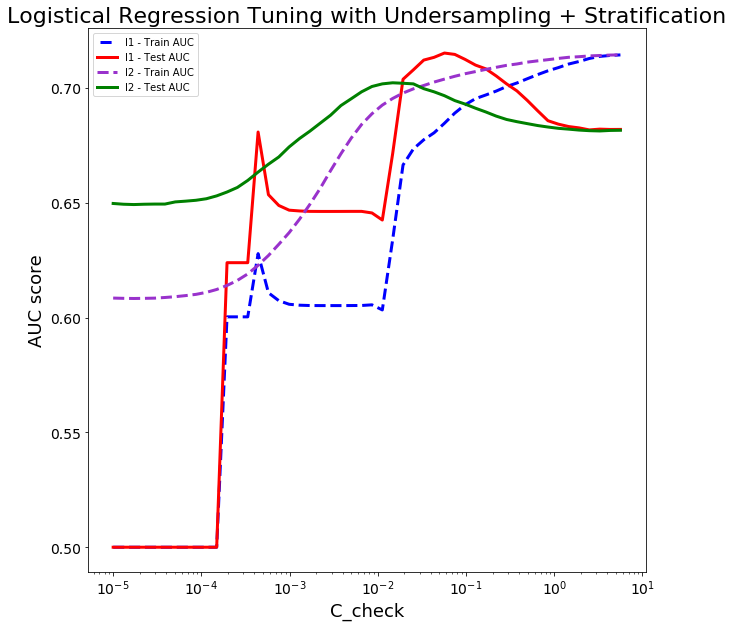

In [13]:
## Logistic Regression Tuning with undersampling + Stratification Class Balancing
from sklearn.linear_model import LogisticRegression
from matplotlib.legend_handler import HandlerLine2D
# Create logistic regression
lr = LogisticRegression(solver = 'liblinear')
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(-5, 0.75, 50)

train_results = []
test_results = []
plt.figure(figsize=(10,10))
for pen_check in penalty:
    l1_train=train_results
    l1_tr=test_results
    train_results = []
    test_results = []
    for C_check in C:
        lr = LogisticRegression(solver = 'liblinear',C=C_check,penalty=pen_check)
        lr.fit(X_train_us_str, y_train_us_str)

        train_pred = lr.predict_proba(X_train_us_str)[:,1]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_us_str, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)

        y_pred = lr.predict_proba(X_test_us_str)[:,1]

        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_us_str, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)


    if pen_check=='l1':
        line1, = plt.plot(C, train_results, 'b', label="l1 - Train AUC",linewidth=3,linestyle='--')
        line2, = plt.plot(C, test_results, 'r', label="l1 - Test AUC",linewidth=3)
    elif pen_check == 'l2':
        line3, = plt.plot(C, train_results, 'darkorchid', label="l2 - Train AUC",linewidth=3,linestyle='--')
        line4, = plt.plot(C, test_results, 'g', label="l2 - Test AUC",linewidth=3)
    

for i in range(len(l1_tr)):
        if abs(l1_tr[i]-l1_train[i])>0.04 or l1_tr[i]>l1_train[i]:
            l1_tr[i]=0
        if abs(train_results[i]-test_results[i])>0.04 or train_results[i]<test_results[i]:
            test_results[i]=0
if max(l1_tr)>max(test_results):
    index=np.argmax(l1_tr)
    lr_pen_us_str='l1'
    lr_c_us_str=C[index]
    lr_auc_us_str=l1_tr[index]
    print('The optimal penalty is l1.')
    print('The optimal C is: ',C[index])
else:
    index=np.argmax(test_results)
    lr_pen_us_str='l2'
    lr_c_us_str=C[index]
    lr_auc_us_str=test_results[index]
    print('The optimal penalty is l2.')
    print('The optimal C is: ',C[index])

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score',fontsize=18)
plt.xscale('log')
plt.title('Logistical Regression Tuning with Undersampling + Stratification', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('C_check', fontsize=18)
#plt.xlim(0,200)
#plt.savefig('LR Tuning.png')
plt.show()

The optimal Number of estimators is:  200


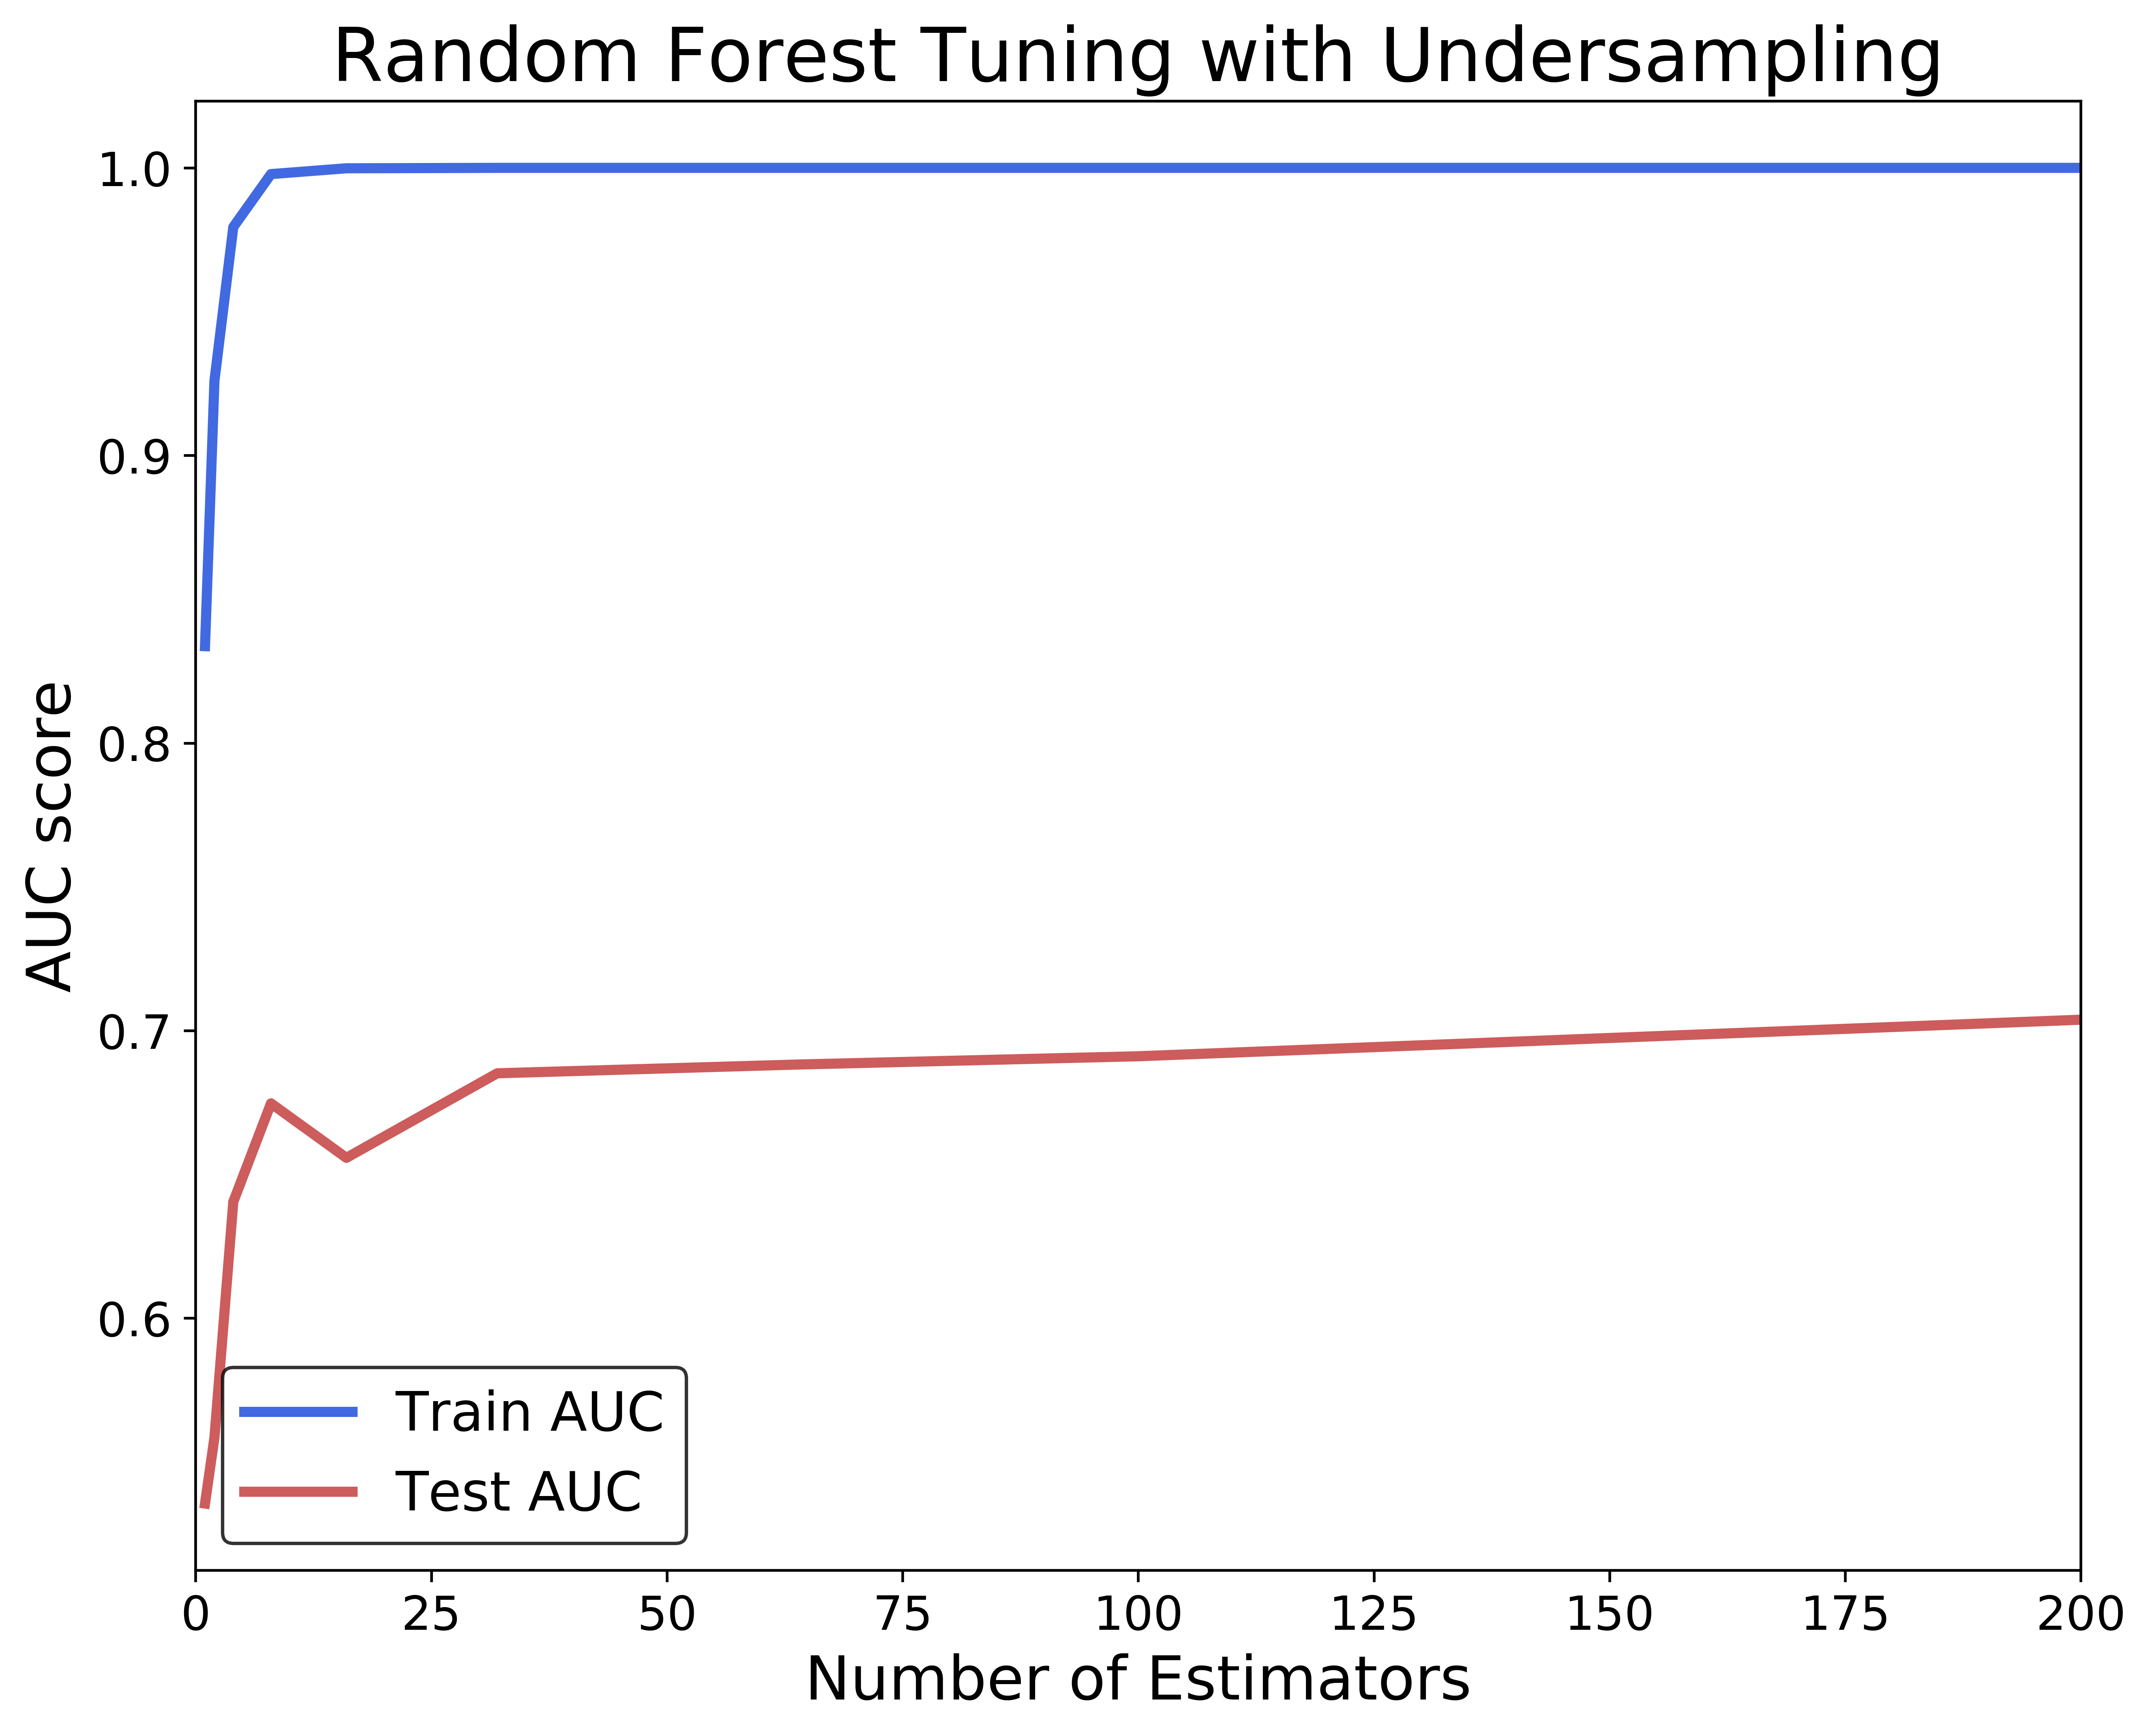

In [52]:
# tuning the random forest classifier first for the number of estimators
# this was done first with simply stratification then changed to use the undersampled data
    # The results were quite similar with neraly no additional gain from increasing the estimators past 100
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

train_results = []
test_results = []
plt.figure(figsize=(10,8),dpi=600)
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1,criterion='gini')
   rf.fit(X_train_us_str, y_train_us_str)

   train_pred = rf.predict_proba(X_train_us_str)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_us_str, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict_proba(X_test_us_str)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_us_str, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, 'royalblue', label="Train AUC",linewidth=3)
line2, = plt.plot(n_estimators, test_results, 'indianred', label="Test AUC",linewidth=3)

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score',fontsize=18)
plt.title('Random Forest Tuning with Undersampling', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(edgecolor='black',fontsize=16)
plt.xlabel('Number of Estimators', fontsize=18)
#plt.xlim(0,200)
index=np.argmax(test_results)
print('The optimal Number of estimators is: ',n_estimators[index])
plt.savefig('RF_Nest Tuning.png')
plt.xlim(0,200)
plt.show()

The optimal Depth is:  5.0


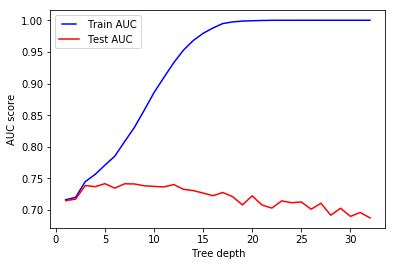

In [28]:
#Max Depth tuning for no balancing
# Done with a for loop through a linspace of possible depths
# This code is replicated for the next several instances to test the various data scaling approaches
max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth,n_estimators=100, n_jobs=-1)
   rf.fit(X_train, y_train)

   train_pred = rf.predict_proba(X_train)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict_proba(X_test)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# Can through for undesired results 
    # Overfitting or exceeding the train results
for i in range(len(train_results)):
    if abs(train_results[i]-test_results[i])>0.04 or test_results[i]>train_results[i]:
        test_results[i]=0
        
# storing the max auc-roc for later comparison
index=np.argmax(test_results)
rf_md_nb=max_depths[index]
rf_auc_nb=test_results[index]
print('The optimal Depth is: ',max_depths[index])
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

The optimal Depth is:  4.0


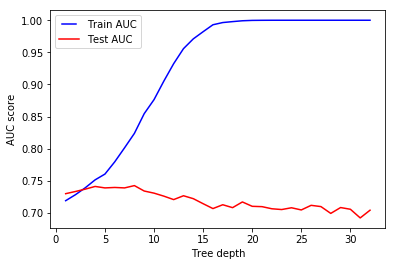

In [29]:
#Max Depth tuning for Class_weight balancing
max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth,n_estimators=100,class_weight='balanced', n_jobs=-1)
   rf.fit(X_train, y_train)

   train_pred = rf.predict_proba(X_train)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict_proba(X_test)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
for i in range(len(train_results)):
    if abs(train_results[i]-test_results[i])>0.04 or test_results[i]>train_results[i]:
        test_results[i]=0
index=np.argmax(test_results)
rf_md_cw=max_depths[index]
rf_auc_cw=test_results[index]
print('The optimal Depth is: ',max_depths[index])
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

The optimal Depth is:  4.0


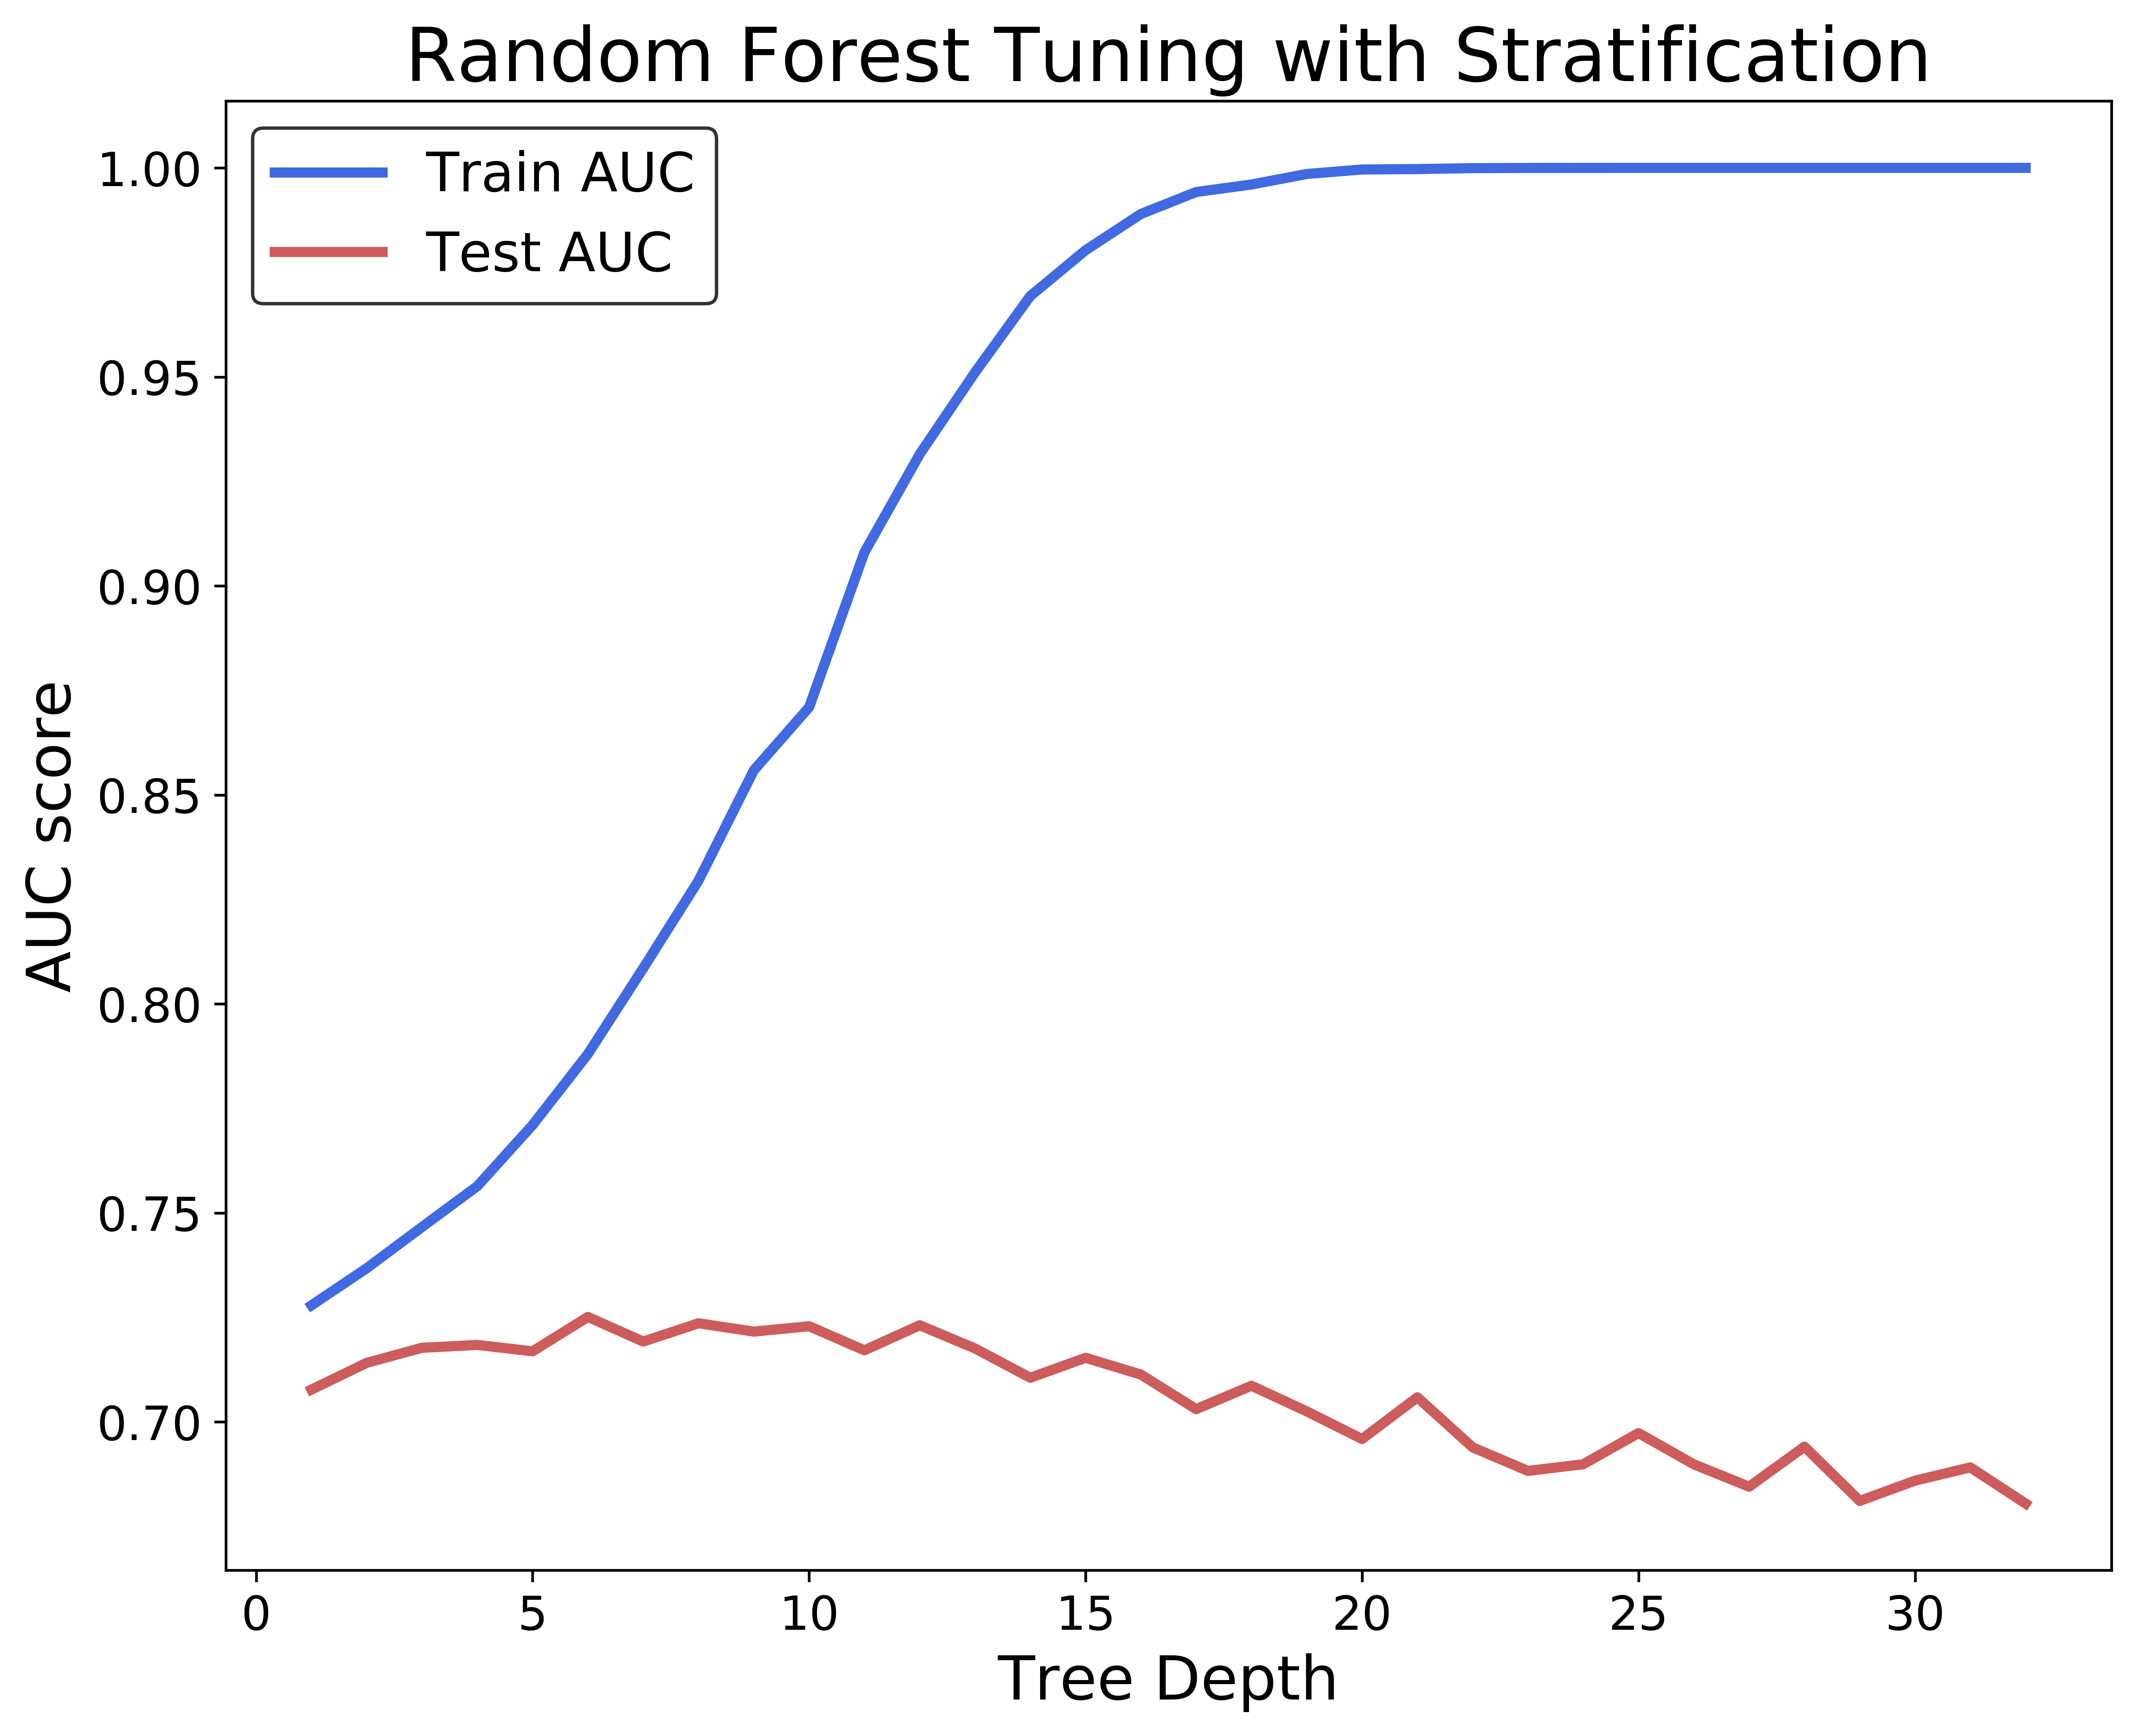

In [30]:
#Max Depth tuning for sample stratification
max_depths = np.linspace(1, 32, 32, endpoint=True)

train_results = []
test_results = []
plt.figure(figsize=(10,8),dpi=600)
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth,n_estimators=100, n_jobs=-1)
   rf.fit(X_train_strat, y_train_strat)

   train_pred = rf.predict_proba(X_train_strat)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_strat, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict_proba(X_test_strat)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_strat, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'royalblue', label='Train AUC',linewidth=3)
line2, = plt.plot(max_depths, test_results, 'indianred', label='Test AUC',linewidth=3)

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
for i in range(len(train_results)):
    if abs(train_results[i]-test_results[i])>0.04 or test_results[i]>train_results[i]:
        test_results[i]=0
index=np.argmax(test_results)
rf_md_str=max_depths[index]
rf_auc_str=test_results[index]
print('The optimal Depth is: ',max_depths[index])
plt.ylabel('AUC score',fontsize=18)
plt.title('Random Forest Tuning with Stratification', fontsize=22)
plt.legend(edgecolor='black',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Tree Depth', fontsize=18)
#plt.xlim(0,200)
#plt.savefig('RF_Depth Tuning.png')

plt.show()

The optimal Depth is:  4.0


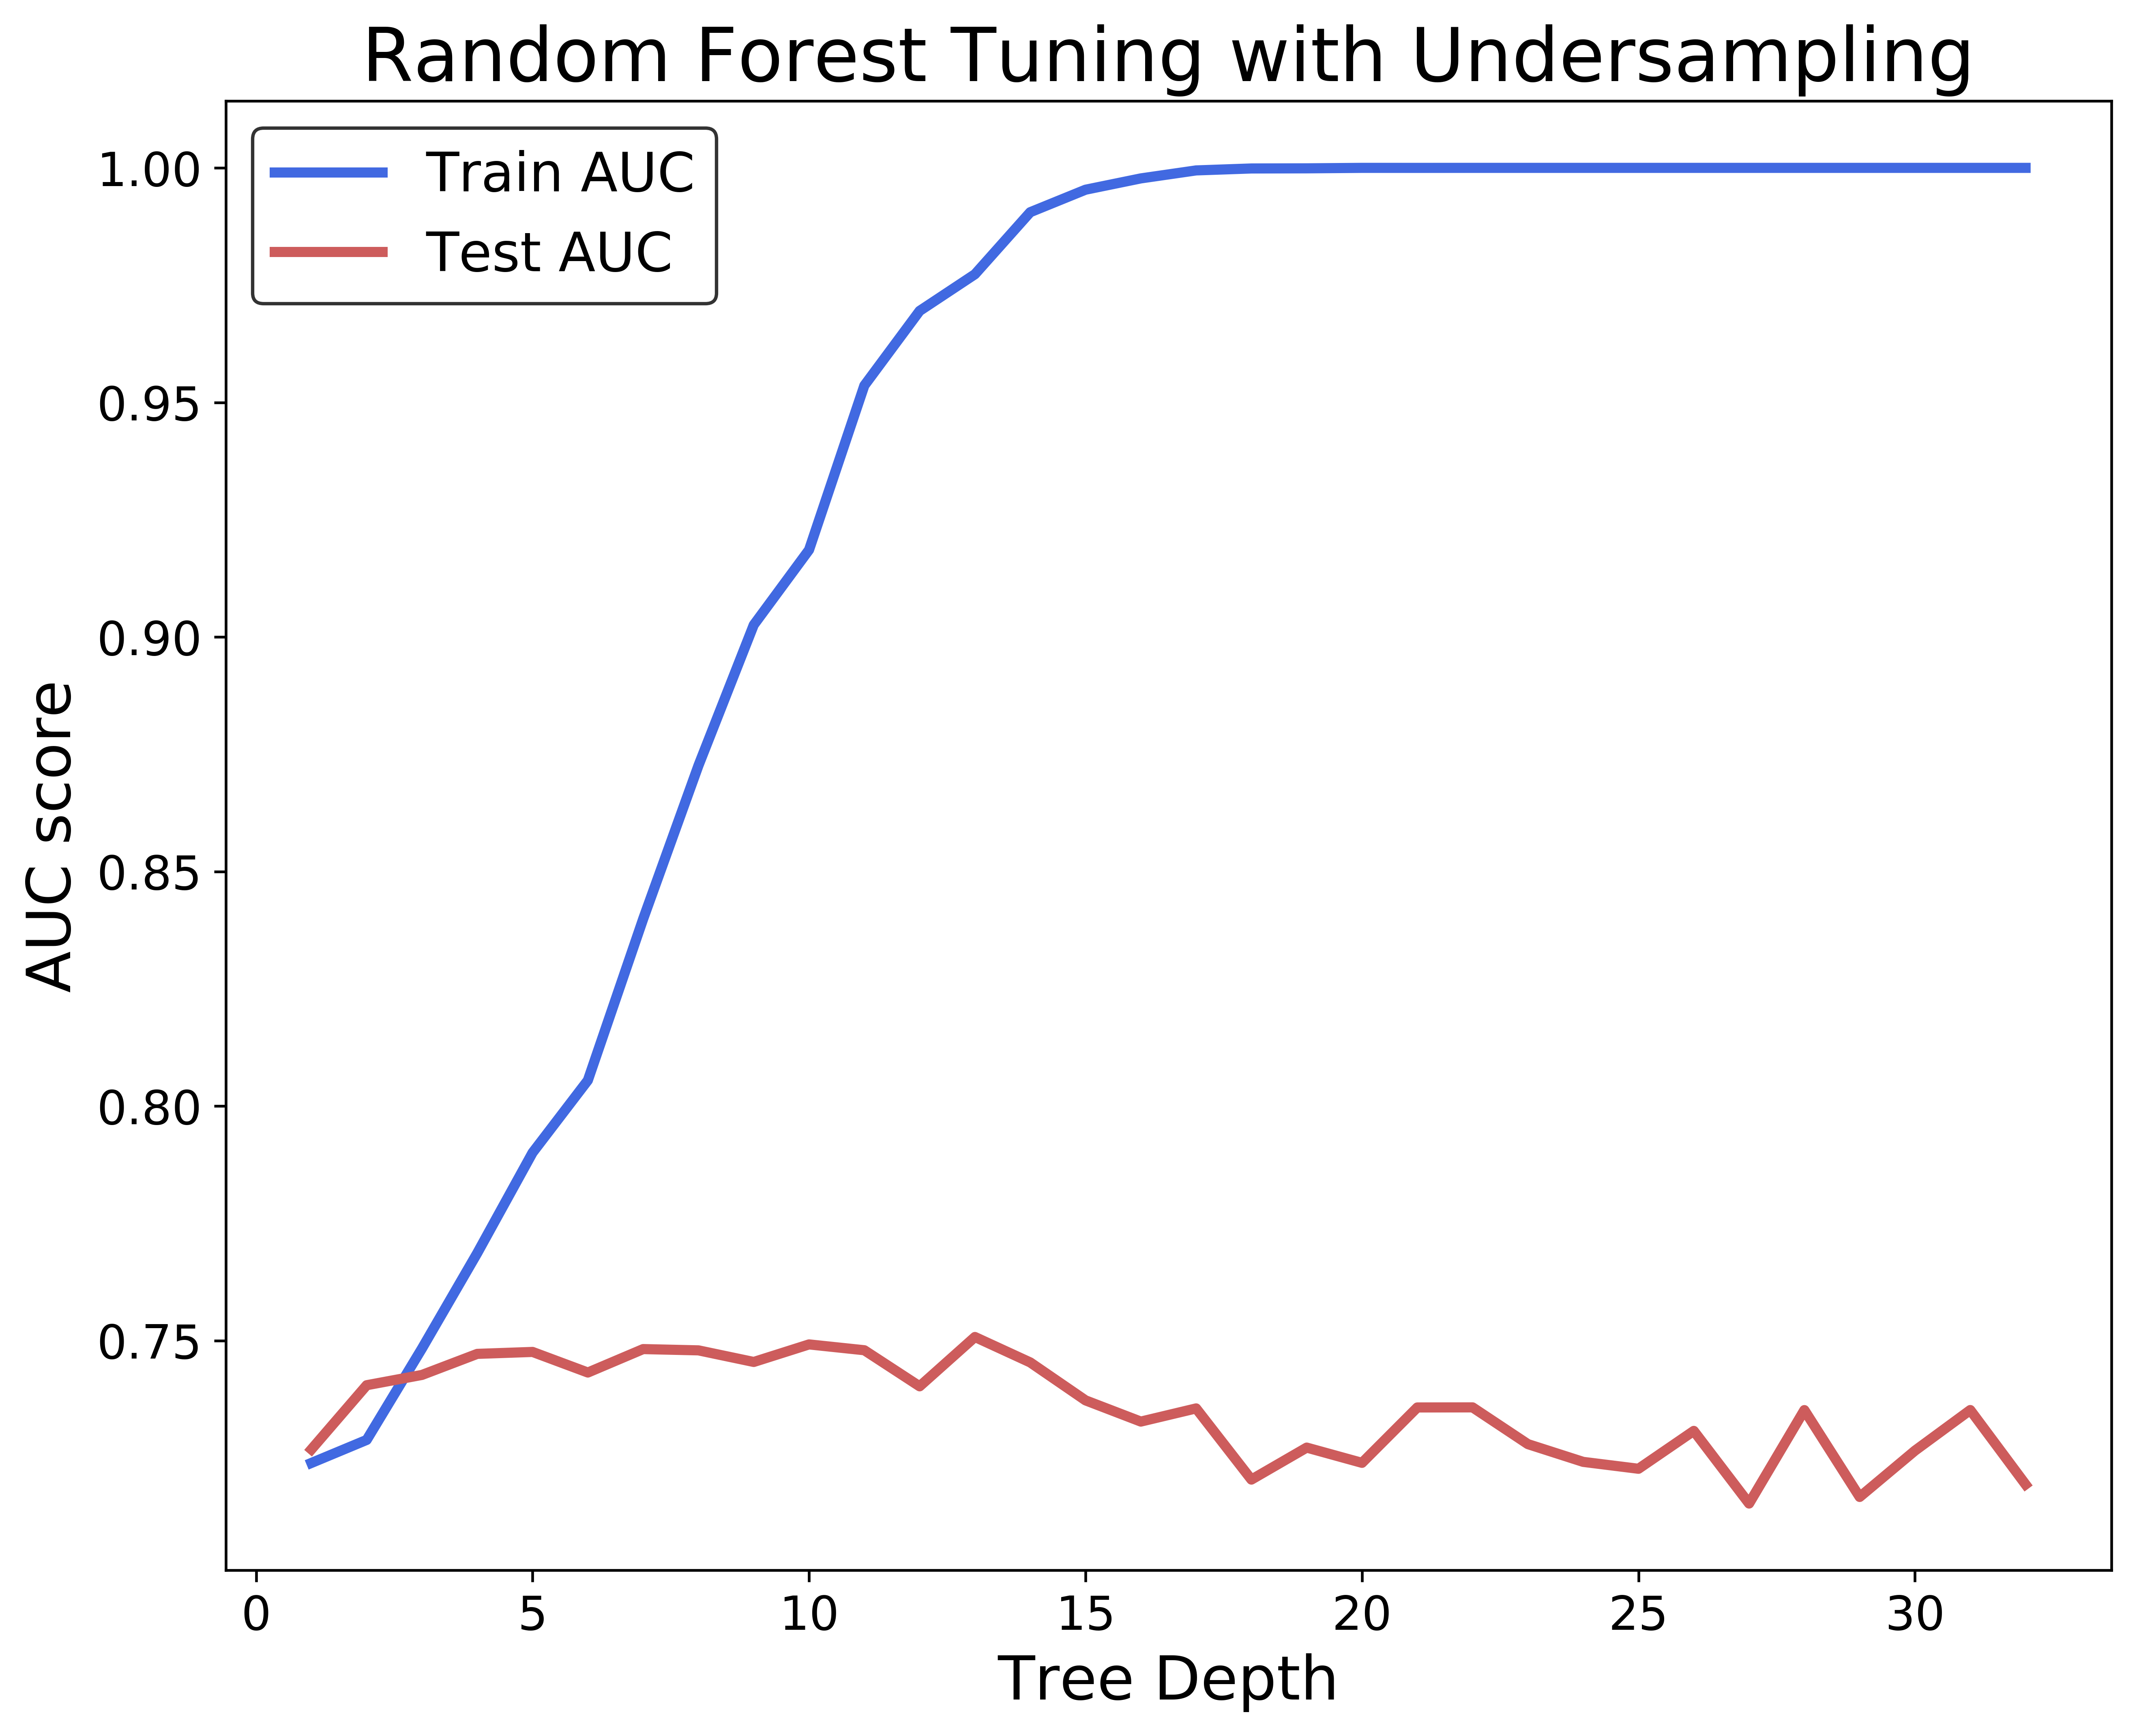

In [31]:
#Max Depth tuning for undersampling
max_depths = np.linspace(1, 32, 32, endpoint=True)
plt.figure(figsize=(10,8),dpi=600)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth,n_estimators=100, n_jobs=-1)
   rf.fit(X_train_us, y_train_us)

   train_pred = rf.predict_proba(X_train_us)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_us, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict_proba(X_test_us)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_us, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'royalblue', label='Train AUC',linewidth=3)
line2, = plt.plot(max_depths, test_results, 'indianred', label='Test AUC',linewidth=3)

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
for i in range(len(train_results)):
    if abs(train_results[i]-test_results[i])>0.04 or test_results[i]>train_results[i]:
        test_results[i]=0
index=np.argmax(test_results)
rf_md_us=max_depths[index]
rf_auc_us=test_results[index]
print('The optimal Depth is: ',max_depths[index])
plt.ylabel('AUC score',fontsize=18)
plt.title('Random Forest Tuning with Undersampling', fontsize=22)
plt.legend(edgecolor='black',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Tree Depth', fontsize=18)
#plt.xlim(0,200)
#plt.savefig('RF_Depth Tuning.png')

The optimal Depth is:  5.0


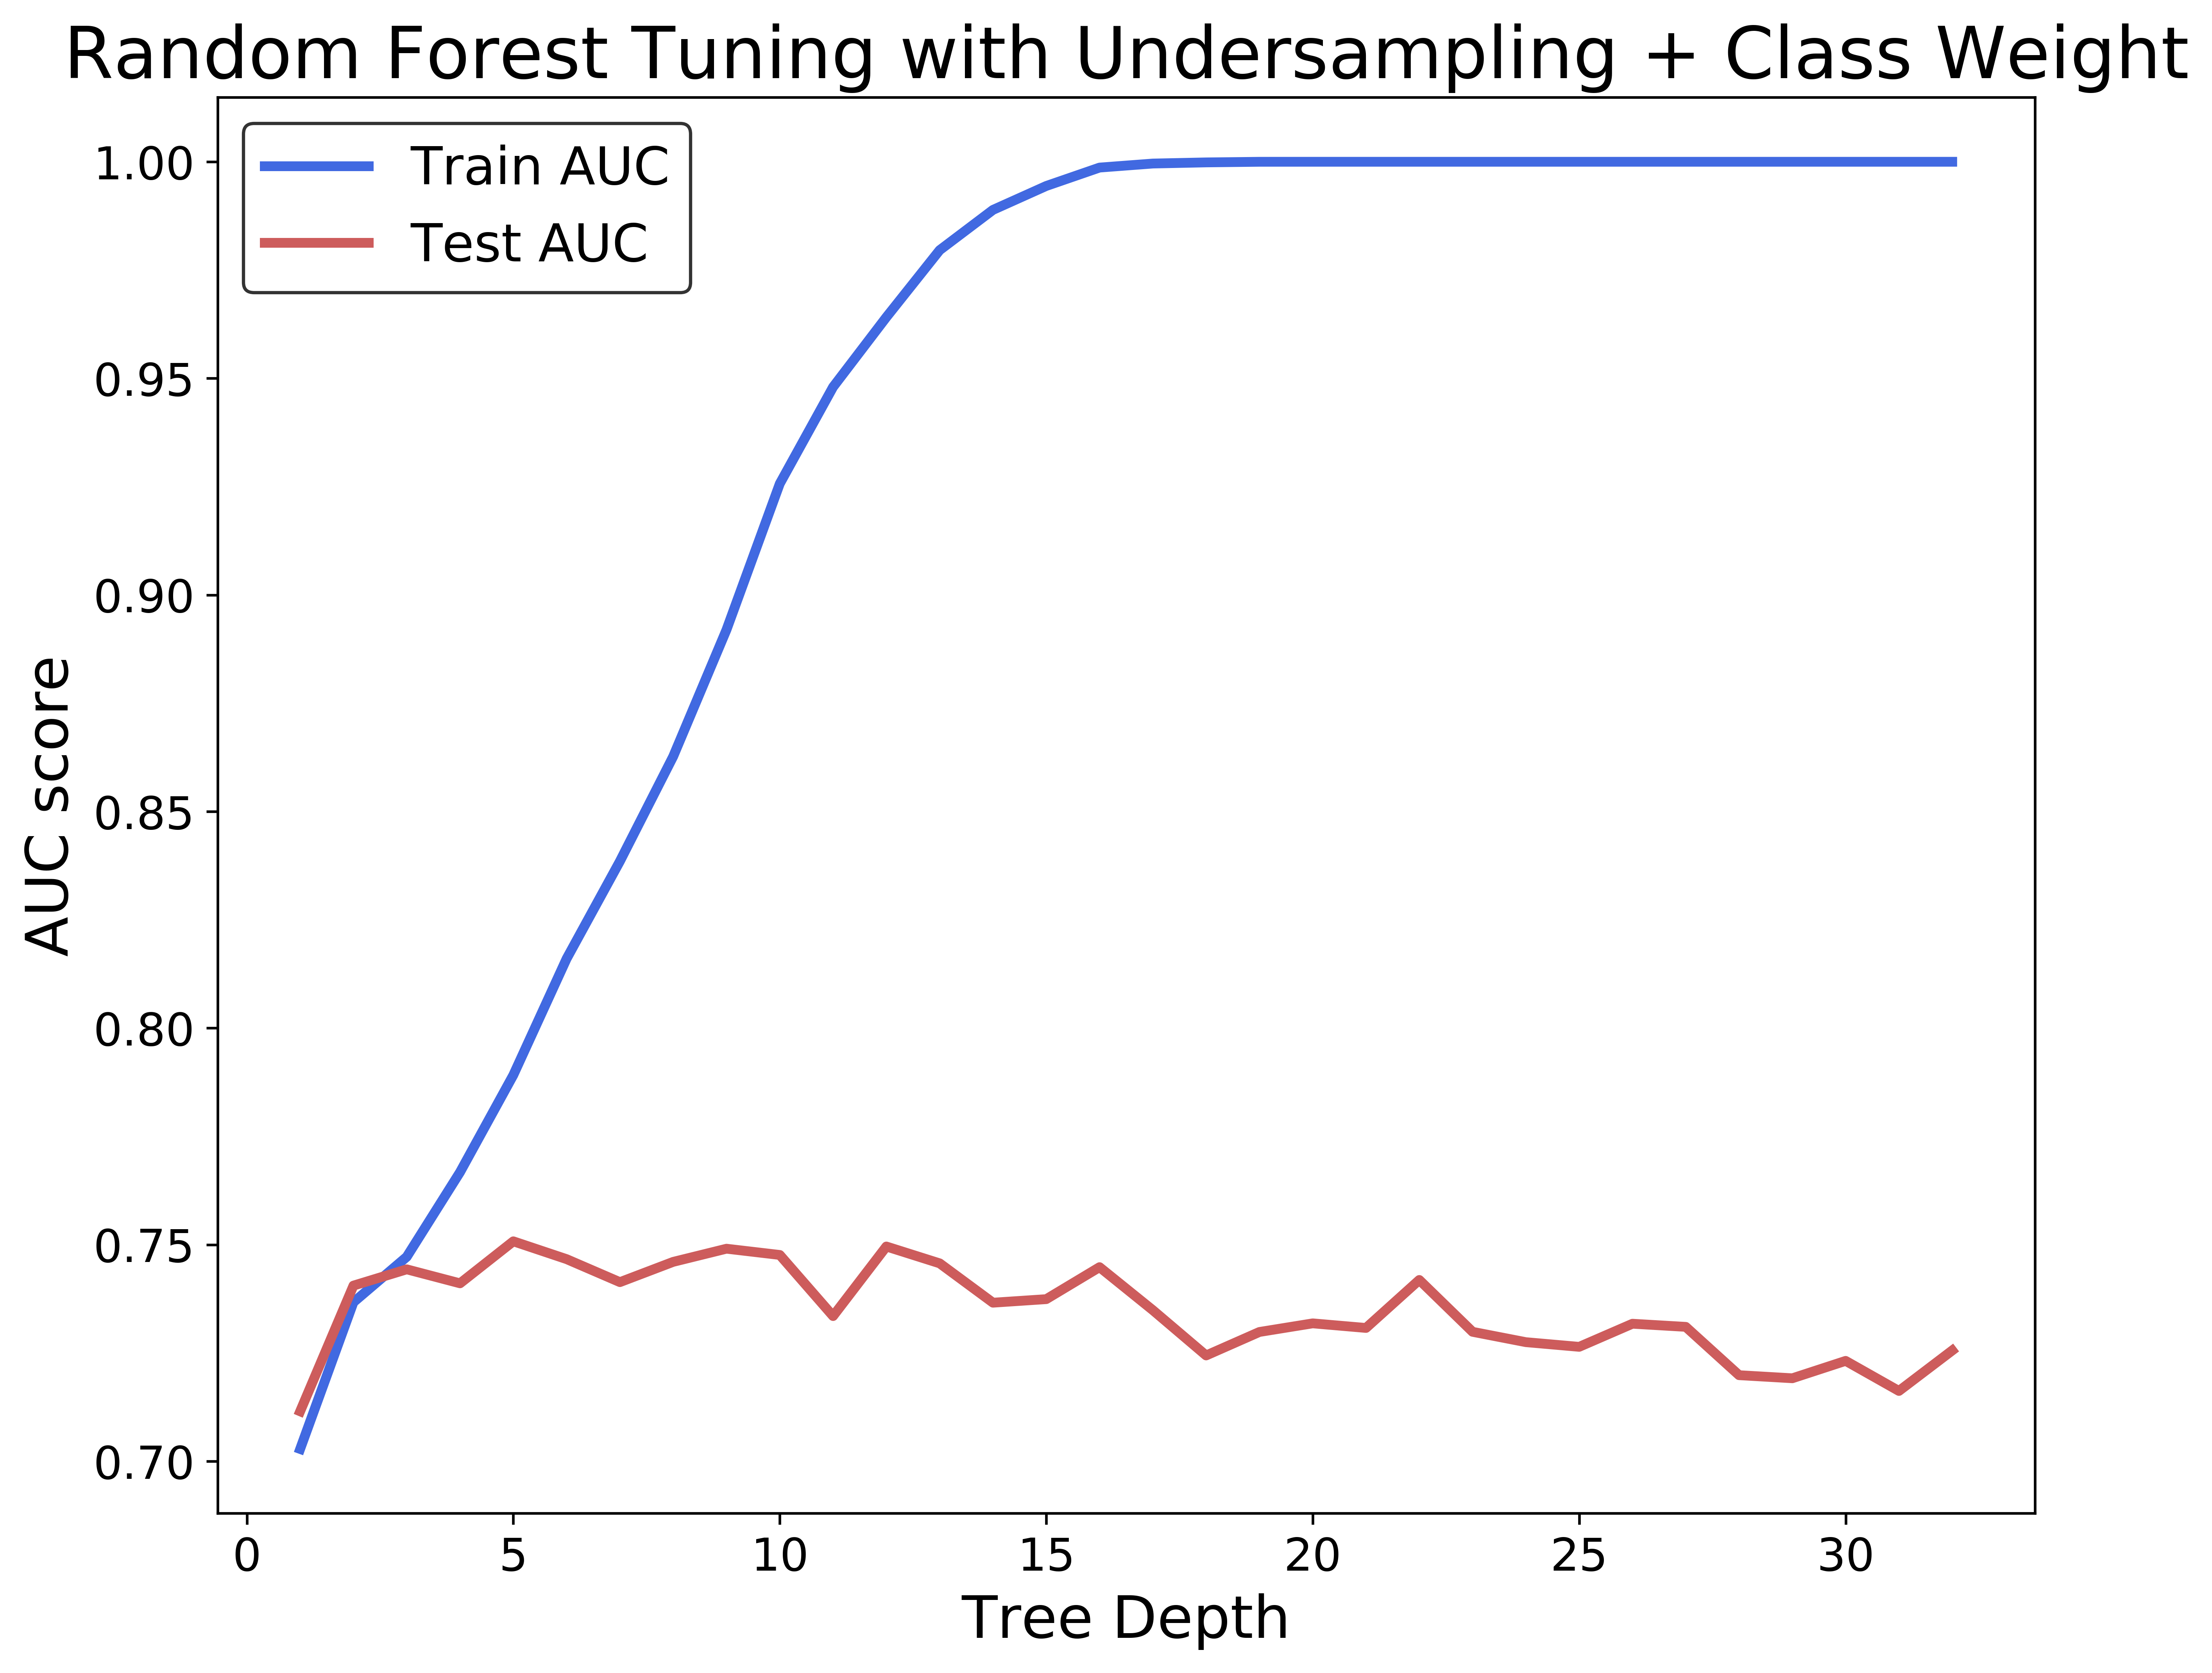

In [33]:
#Max Depth tuning for undersampling + Class Weighting
max_depths = np.linspace(1, 32, 32, endpoint=True)
plt.figure(figsize=(10,8),dpi=600)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth,n_estimators=100,class_weight='balanced', n_jobs=-1)
   rf.fit(X_train_us, y_train_us)

   train_pred = rf.predict_proba(X_train_us)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_us, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict_proba(X_test_us)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_us, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'royalblue', label='Train AUC',linewidth=3)
line2, = plt.plot(max_depths, test_results, 'indianred', label='Test AUC',linewidth=3)

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
for i in range(len(train_results)):
    if abs(train_results[i]-test_results[i])>0.04 or test_results[i]>train_results[i]:
        test_results[i]=0
index=np.argmax(test_results)
rf_md_us_cw=max_depths[index]
rf_auc_us_cw=test_results[index]
print('The optimal Depth is: ',max_depths[index])
plt.ylabel('AUC score',fontsize=18)
plt.title('Random Forest Tuning with Undersampling + Class Weight', fontsize=22)
plt.legend(edgecolor='black',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Tree Depth', fontsize=18)
#plt.xlim(0,200)
#plt.savefig('RF_Depth Tuning.png')

The optimal Depth is:  5.0


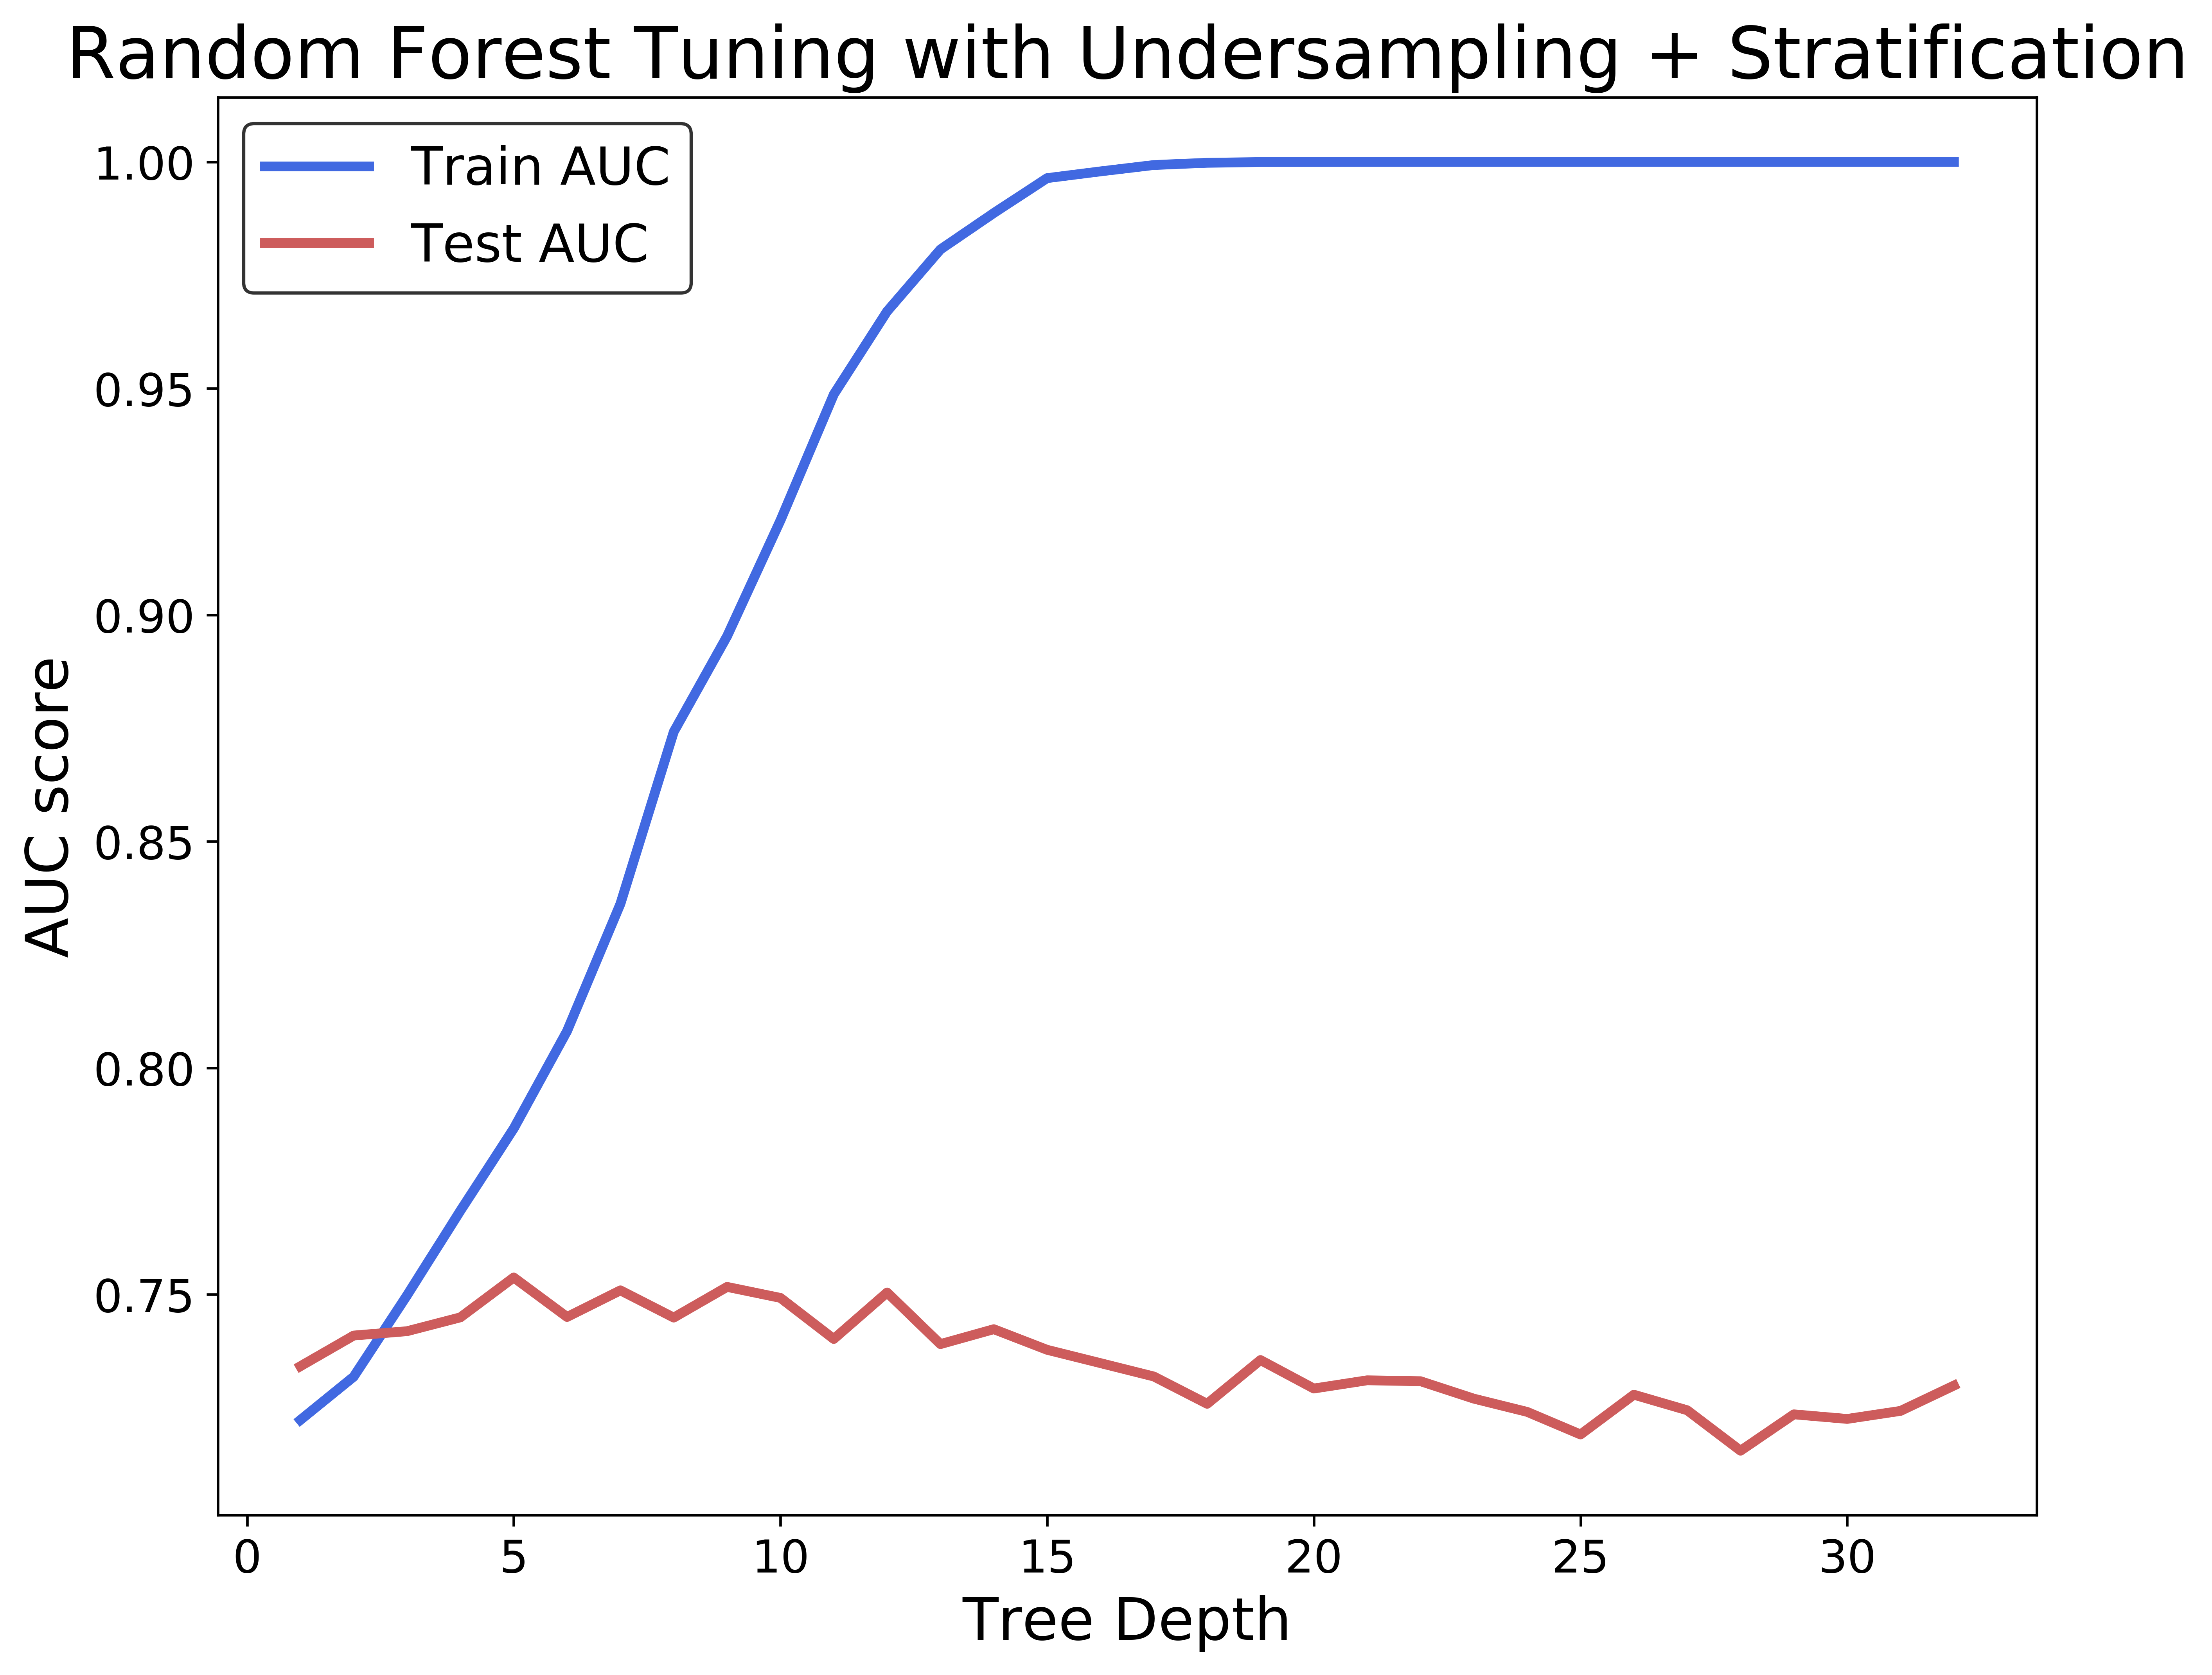

In [34]:
#Max Depth tuning for undersampling + Stratification
max_depths = np.linspace(1, 32, 32, endpoint=True)
plt.figure(figsize=(10,8),dpi=600)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth,n_estimators=100, n_jobs=-1)
   rf.fit(X_train_us, y_train_us)

   train_pred = rf.predict_proba(X_train_us)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_us, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred = rf.predict_proba(X_test_us)[:,1]

   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_us, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'royalblue', label='Train AUC',linewidth=3)
line2, = plt.plot(max_depths, test_results, 'indianred', label='Test AUC',linewidth=3)

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
for i in range(len(train_results)):
    if abs(train_results[i]-test_results[i])>0.04 or test_results[i]>train_results[i]:
        test_results[i]=0
index=np.argmax(test_results)
rf_md_us_str=max_depths[index]
rf_auc_us_str=test_results[index]
print('The optimal Depth is: ',max_depths[index])
plt.ylabel('AUC score',fontsize=18)
plt.title('Random Forest Tuning with Undersampling + Stratification', fontsize=22)
plt.legend(edgecolor='black',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Tree Depth', fontsize=18)
#plt.xlim(0,200)
plt.savefig('RF_Depth Tuning.png')

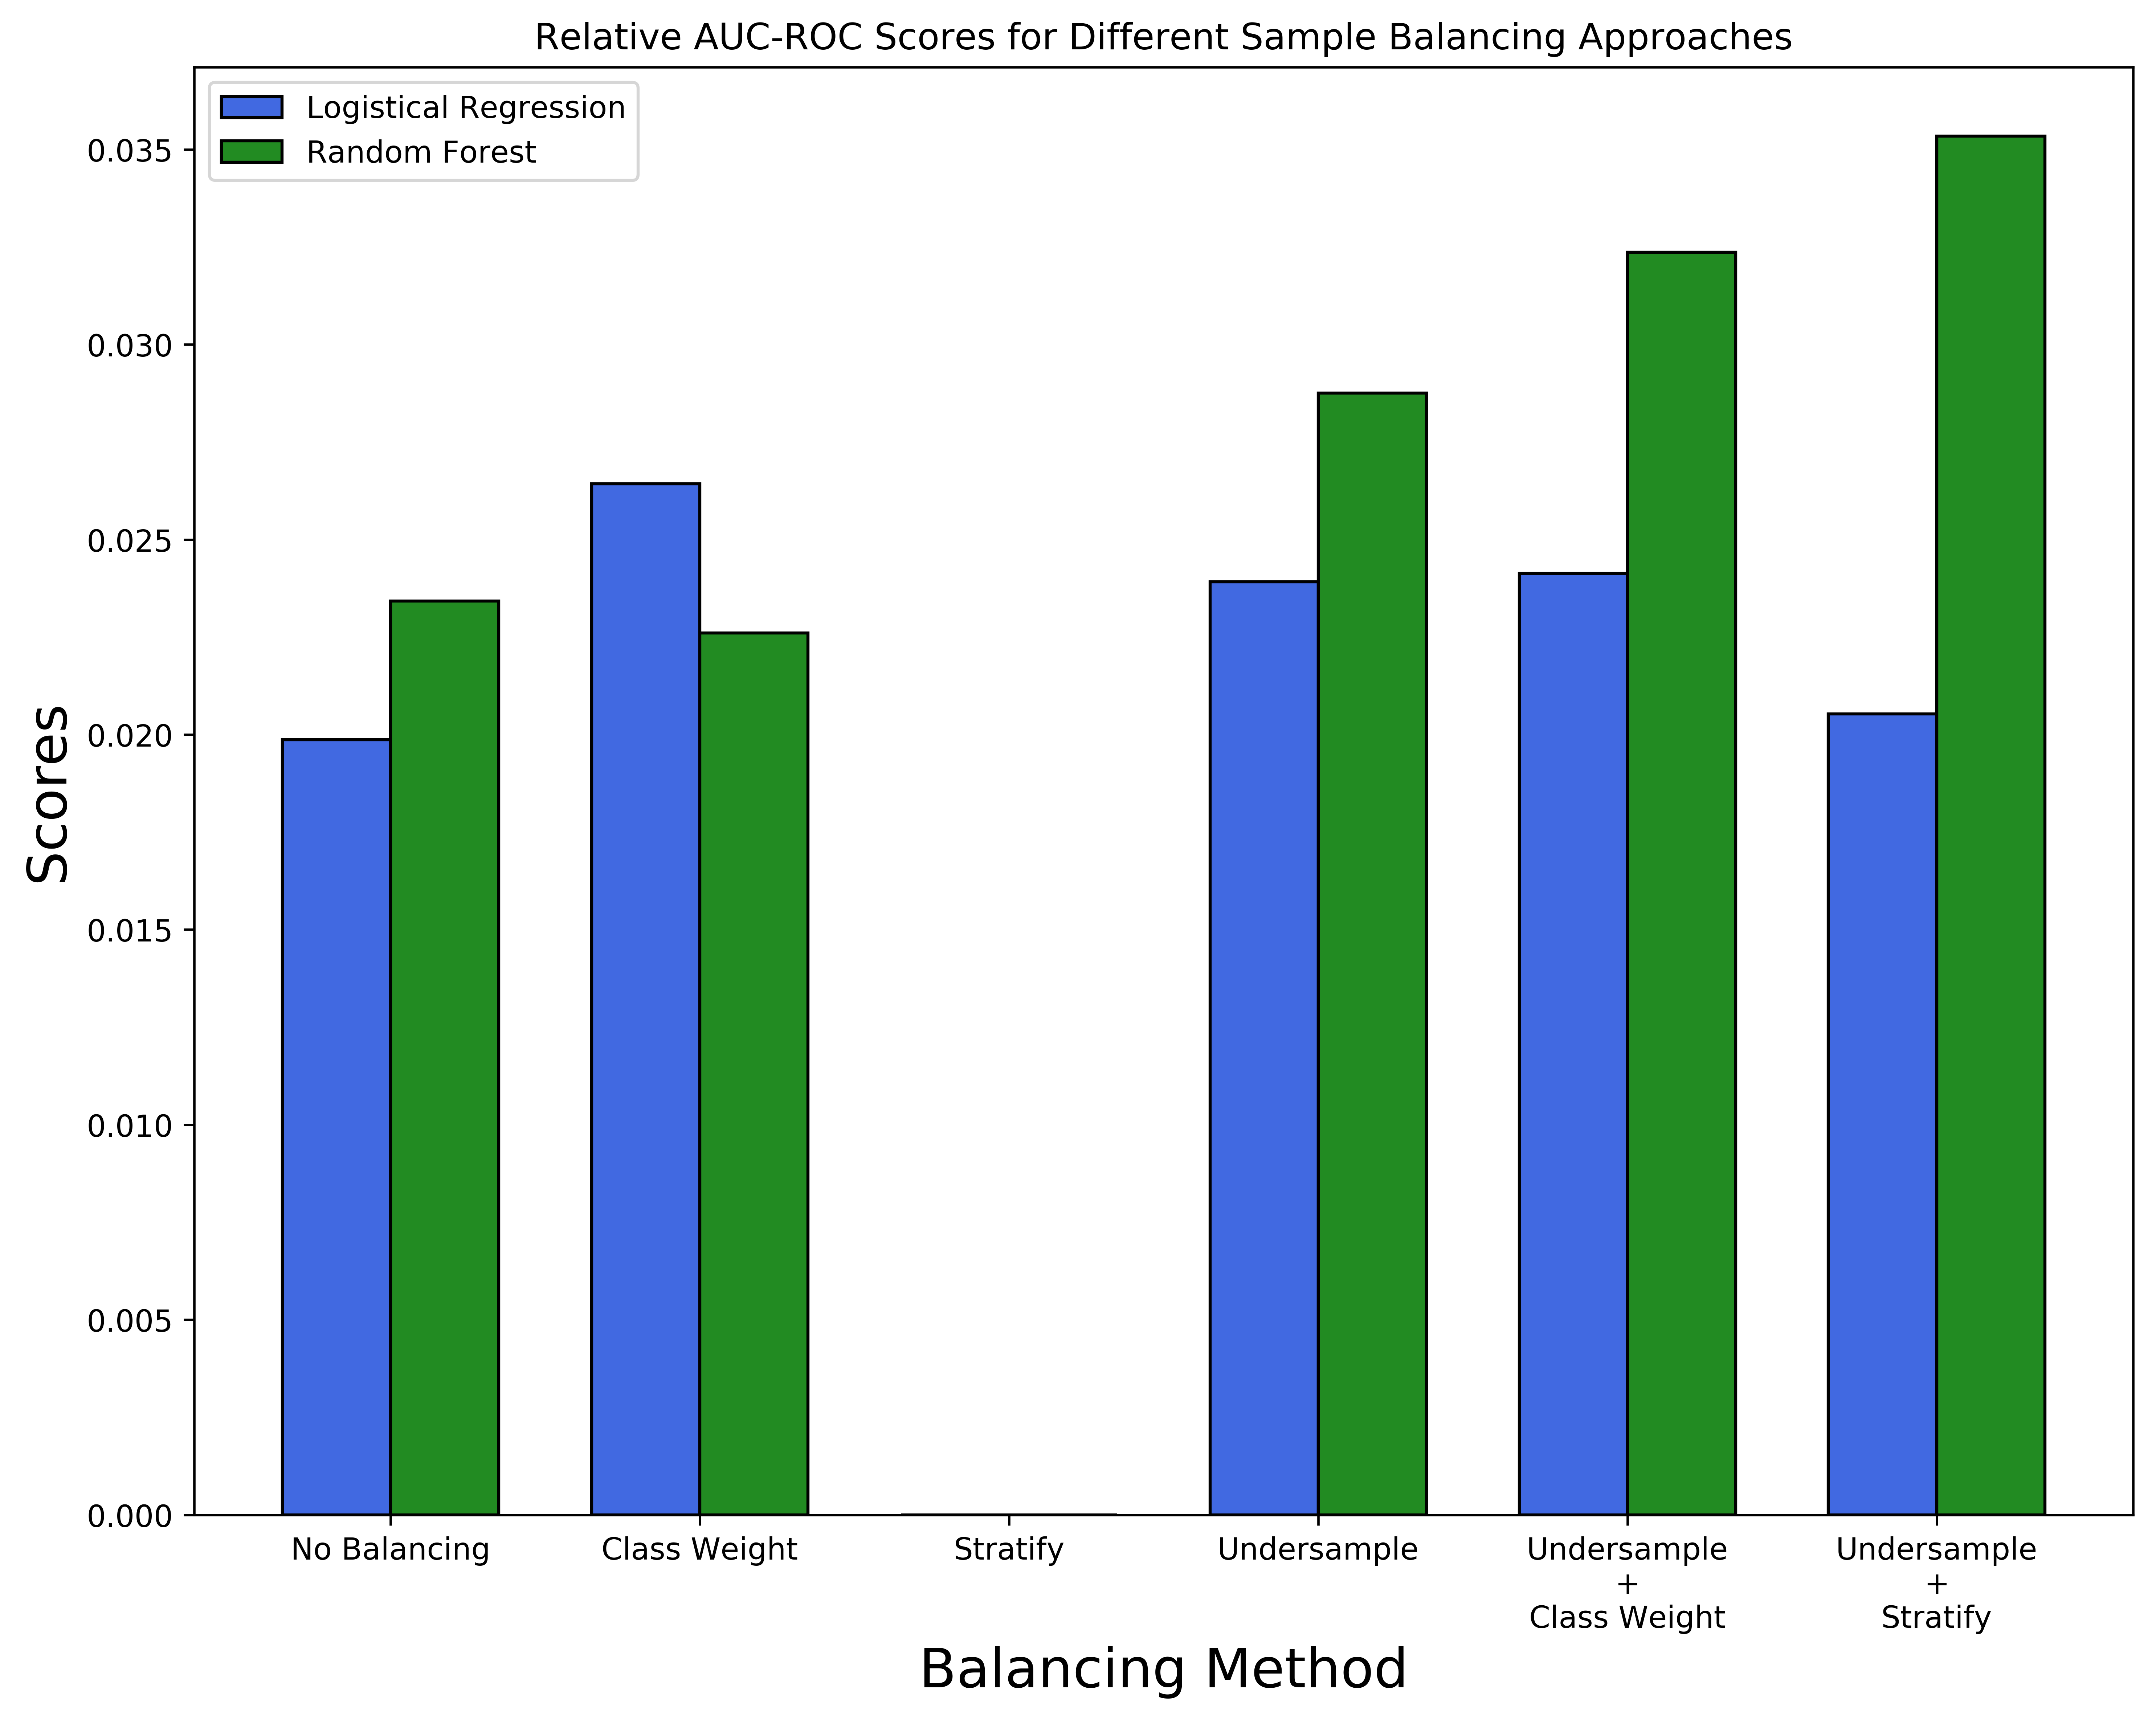

In [35]:
## Plotting the results from the tests in the above cells
# ***********************************************************************************
fig, ax = plt.subplots(figsize=(10,8),dpi=600)
index = np.arange(6)
bar_width = 0.35
opacity = 0.8
# First the min value is obtained, then subtracted from each value to plot their increases
    # better visualizes the best approach
minlr=np.min([lr_auc_nb,lr_auc_cw,lr_auc_str,lr_auc_us,lr_auc_us_cw,lr_auc_us_str])
ax.bar(index,[lr_auc_nb,lr_auc_cw,lr_auc_str,lr_auc_us,lr_auc_us_cw,lr_auc_us_str]-minlr,bar_width
       ,color='royalblue',edgecolor='black',label='Logistical Regression')
minrf=np.min([rf_auc_nb,rf_auc_cw,rf_auc_str,rf_auc_us,rf_auc_us_cw,rf_auc_us_str])
ax.bar(index + bar_width,[rf_auc_nb,rf_auc_cw,rf_auc_str,rf_auc_us,rf_auc_us_cw,rf_auc_us_str]-minrf,bar_width
       ,color='forestgreen',edgecolor='black',label='Random Forest')

ax.set_ylabel("Fraction of High Severity", fontsize=18)
ax.set_title('Fraction of High Severity by Age', fontsize=22)
ax.set_xlabel('Age [Yrs]',fontsize=18)

plt.xlabel('Balancing Method')
plt.ylabel('Scores')
plt.title('Relative AUC-ROC Scores for Different Sample Balancing Approaches')
plt.xticks(index + (bar_width/2), ('No Balancing', 'Class Weight','Stratify','Undersample'
                                   ,'Undersample\n+\nClass Weight','Undersample\n+\nStratify'),wrap=True)
plt.legend()
 
plt.tight_layout()
plt.show()
fig.savefig('Sampling_Methods.png')

In [12]:
# Accessment of the xgboost classifier
# as recommended from many resources, this should be done with CV thus gridsearch was 
# implemented for various values to optimize it's parameters

#Fitting against the different forms of balancing follows
# best min child weight = 166.81
# best eta = 0.01
# best max_depth = 3
from xgboost import XGBClassifier
xgbc = XGBClassifier(max_depth=3,eta=0.01)
train_results = []
test_results = []
array =df.values
X = array[:,0:-1]
Y = array[:,-1]

# Create hyperparameter spaces
mdepths = [3,4,5,6,7,8,9,10]
etas = np.linspace(0.01,0.5,8)
#ideal = 0.01
#mcw = np.logspace(0,10,5)


# Create hyperparameter options
#hyperparameters = dict(max_depth=mdepths,min_child_weight=mcw,eta=etas)
hyperparameters = dict(min_child_weight=mcw)

clf = GridSearchCV(xgbc, hyperparameters, cv=5, verbose=0, n_jobs = -1, scoring='roc_auc')
# Fit grid search
best_model = clf.fit(X, Y)
# View best hyperparameters
#print('Best Max Depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best Min Child Weight:', best_model.best_estimator_.get_params()['min_child_weight'])
#print('Best ETA:', best_model.best_estimator_.get_params()['eta'])

Best Min Child Weight: 166.81005372000593


In [23]:
# Accessing xgboost on full stratified
from sklearn.metrics import confusion_matrix
xgbc = XGBClassifier(max_depth=3,eta=0.01,min_child_weight=166.81)
xgbc.fit(X_train_strat, y_train_strat)
xgb_pred = xgbc.predict(X_test_strat)
y_pred_xgb = xgbc.predict_proba(X_test_strat)[:,1]
xgb_predp = xgbc.predict_proba(X_test_strat)
print(confusion_matrix(y_test_strat, xgb_pred))

[[2423    0]
 [ 338    0]]


In [25]:
#Accessing xgboost on US_stratified
from sklearn.metrics import confusion_matrix
xgbc = XGBClassifier(max_depth=3,eta=0.01,min_child_weight=166.81)
xgbc.fit(X_train_us_str, y_train_us_str)
xgb_pred = xgbc.predict(X_test_us_str)
y_pred_xgb = xgbc.predict_proba(X_test_us_str)[:,1]
xgb_predp = xgbc.predict_proba(X_test_us_str)
print(confusion_matrix(y_test_us_str, xgb_pred))

[[209 129]
 [129 209]]


In [26]:
from sklearn.metrics import precision_score
precision_score(y_test_us_str, xgb_pred)

0.6183431952662722

In [27]:
from sklearn.metrics import recall_score
recall_score(y_test_us_str, xgb_pred)

0.6183431952662722

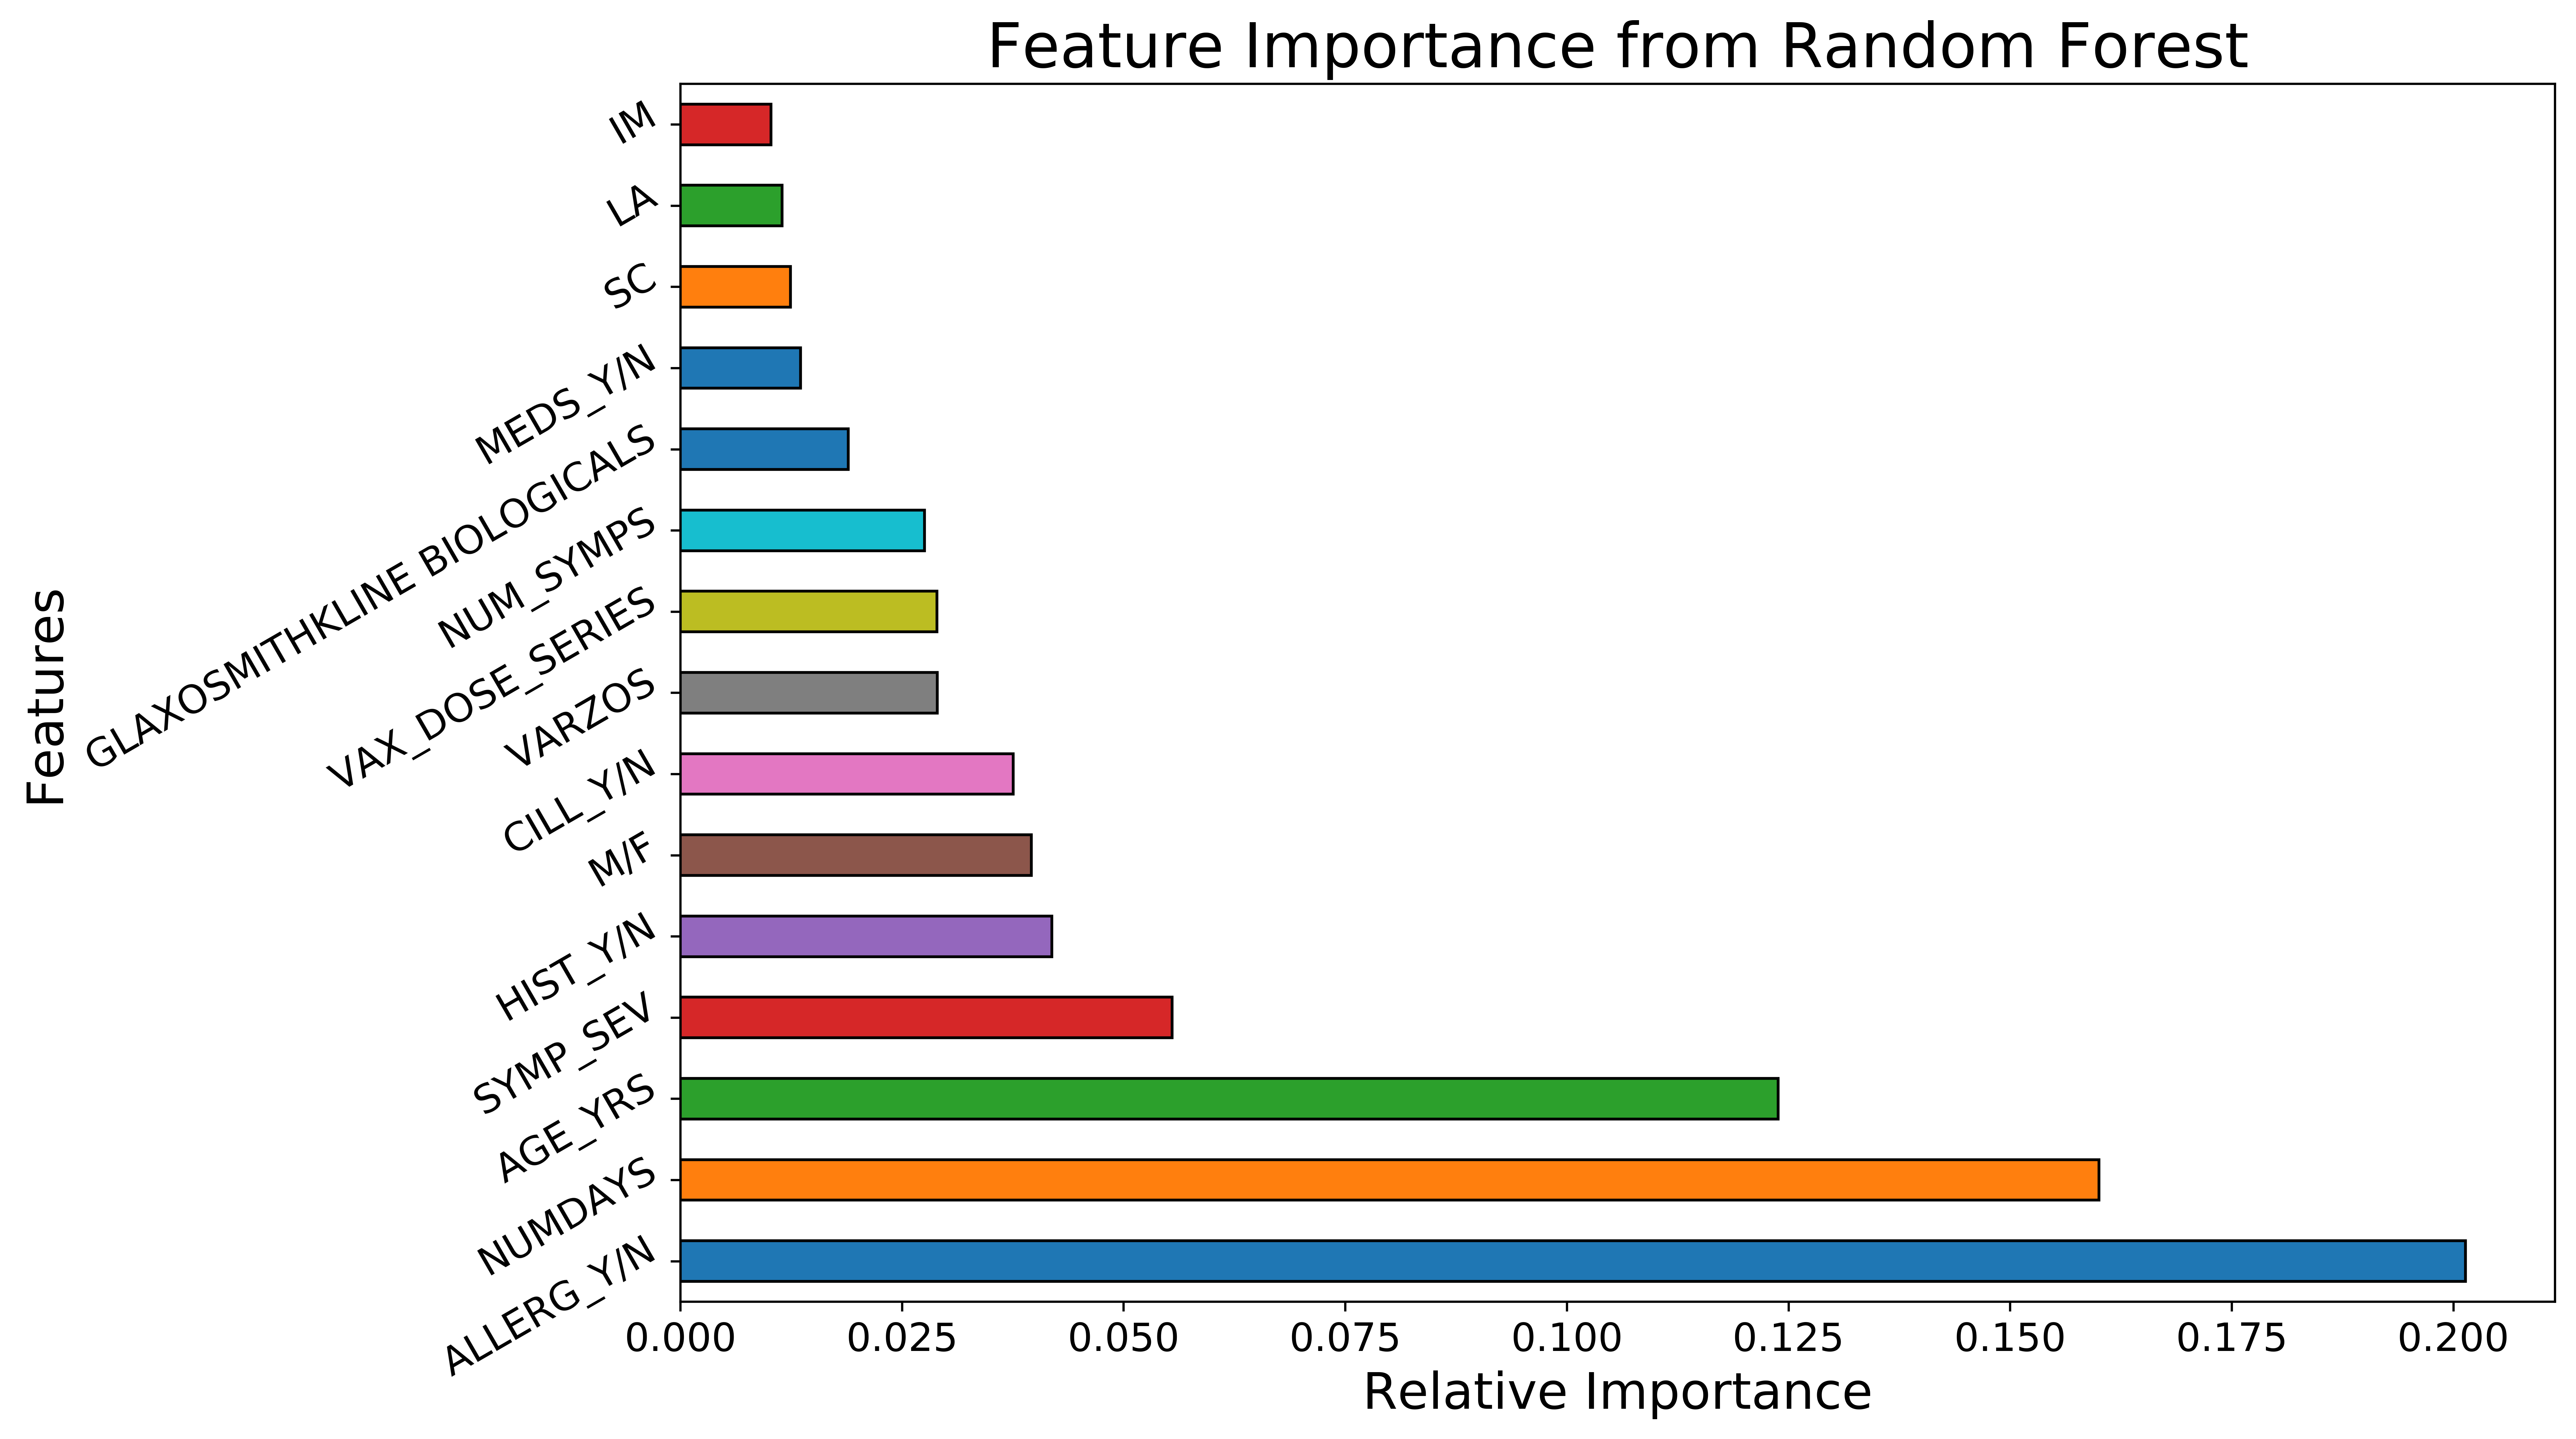

In [36]:
# Extraction of the feature importance data from the random forest classifier
# The impact of reducing the feature space was assessed and found to have little impact on the overall model
    # thus the confusion matrix development was done with the full list of features
plt.figure(figsize=(12,8),dpi=600)
rfc = RandomForestClassifier(bootstrap=True,
                       max_depth=5, n_estimators=100, n_jobs=-1)
rfc.fit(X_train_us_str, y_train_us_str)
feat_importances = pd.Series(rfc.feature_importances_, index=data.columns)
feat_importances.nlargest(15).plot(kind='barh',edgecolor='black')
plt.ylabel('Features',fontsize=18)
plt.xlabel('Relative Importance', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14,wrap=True,rotation=30)
plt.title('Feature Importance from Random Forest',fontsize=22)
plt.savefig('RF_Feature_Importance.png',bbox_inches = 'tight')

In [15]:
# reduction in feature space for comparison of impact
data2=data[['ALLERG_Y/N','NUMDAYS','AGE_YRS','SYMP_SEV','HIST_Y/N','M/F'
           ,'CILL_Y/N','VARZOS','VAX_DOSE_SERIES','NUM_SYMPS','GLAXOSMITHKLINE BIOLOGICALS','MEDS_Y/N','SC','LA','IM']].copy()
X_res2, y_res2 = RandomUnderSampler(random_state=654).fit_sample(data2, labels)
X_train_us2, X_test_us2, y_train_us2, y_test_us2 = train_test_split(X_res2, y_res2, test_size=0.25, random_state=1994)
X_train_us_str2, X_test_us_str2, y_train_us_str2, y_test_us_str2 = train_test_split(X_res2, y_res2, test_size=0.25, stratify=y_res2, random_state=1994)

In [25]:
# plotting the confusion matrix of the reduced feature space 
from sklearn.metrics import confusion_matrix

rfc2 = RandomForestClassifier(bootstrap=True,
                       max_depth=5, n_estimators=100, n_jobs=-1)
rfc2.fit(X_train_us_str2, y_train_us_str2)
rfc_pred2 = rfc2.predict(X_test_us_str2)
y_pred_rfc2 = rfc2.predict_proba(X_test_us_str2)[:,1]
rfc_predp2 = rfc2.predict_proba(X_test_us_str2)
print(confusion_matrix(y_test_us_str2, rfc_pred2))

[[213 125]
 [ 80 258]]


In [6]:
# developing the reduced feature space for the full feature space
# recall is identical in both cases thus no reduction was used for further acessment
from sklearn.metrics import confusion_matrix

rfc = RandomForestClassifier(bootstrap=True,
                       max_depth=5, n_estimators=100, n_jobs=-1)
rfc.fit(X_train_us_str, y_train_us_str)
rfc_pred = rfc.predict(X_test_us_str)
y_pred_rfc = rfc.predict_proba(X_test_us_str)[:,1]
rfc_predp = rfc.predict_proba(X_test_us_str)
print(confusion_matrix(y_test_us_str, rfc_pred))

[[211 127]
 [ 80 258]]


In [27]:
from sklearn.metrics import precision_score
precision_score(y_test_us_str, rfc_pred)

0.6675257731958762

In [28]:
from sklearn.metrics import recall_score
recall_score(y_test_us_str, rfc_pred)

0.7662721893491125

In [5]:
# fitting the logistic regression model and producing the confusion matrix for comparison against LR
# inferior recall was observed
from sklearn.metrics import confusion_matrix
lr = LogisticRegression(solver = 'liblinear',C=0.6475,class_weight='balanced',penalty='l1',fit_intercept=False)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_predp = lr.predict_proba(X_test)
print(confusion_matrix(y_test, lr_pred))

[[1540  874]
 [ 114  233]]


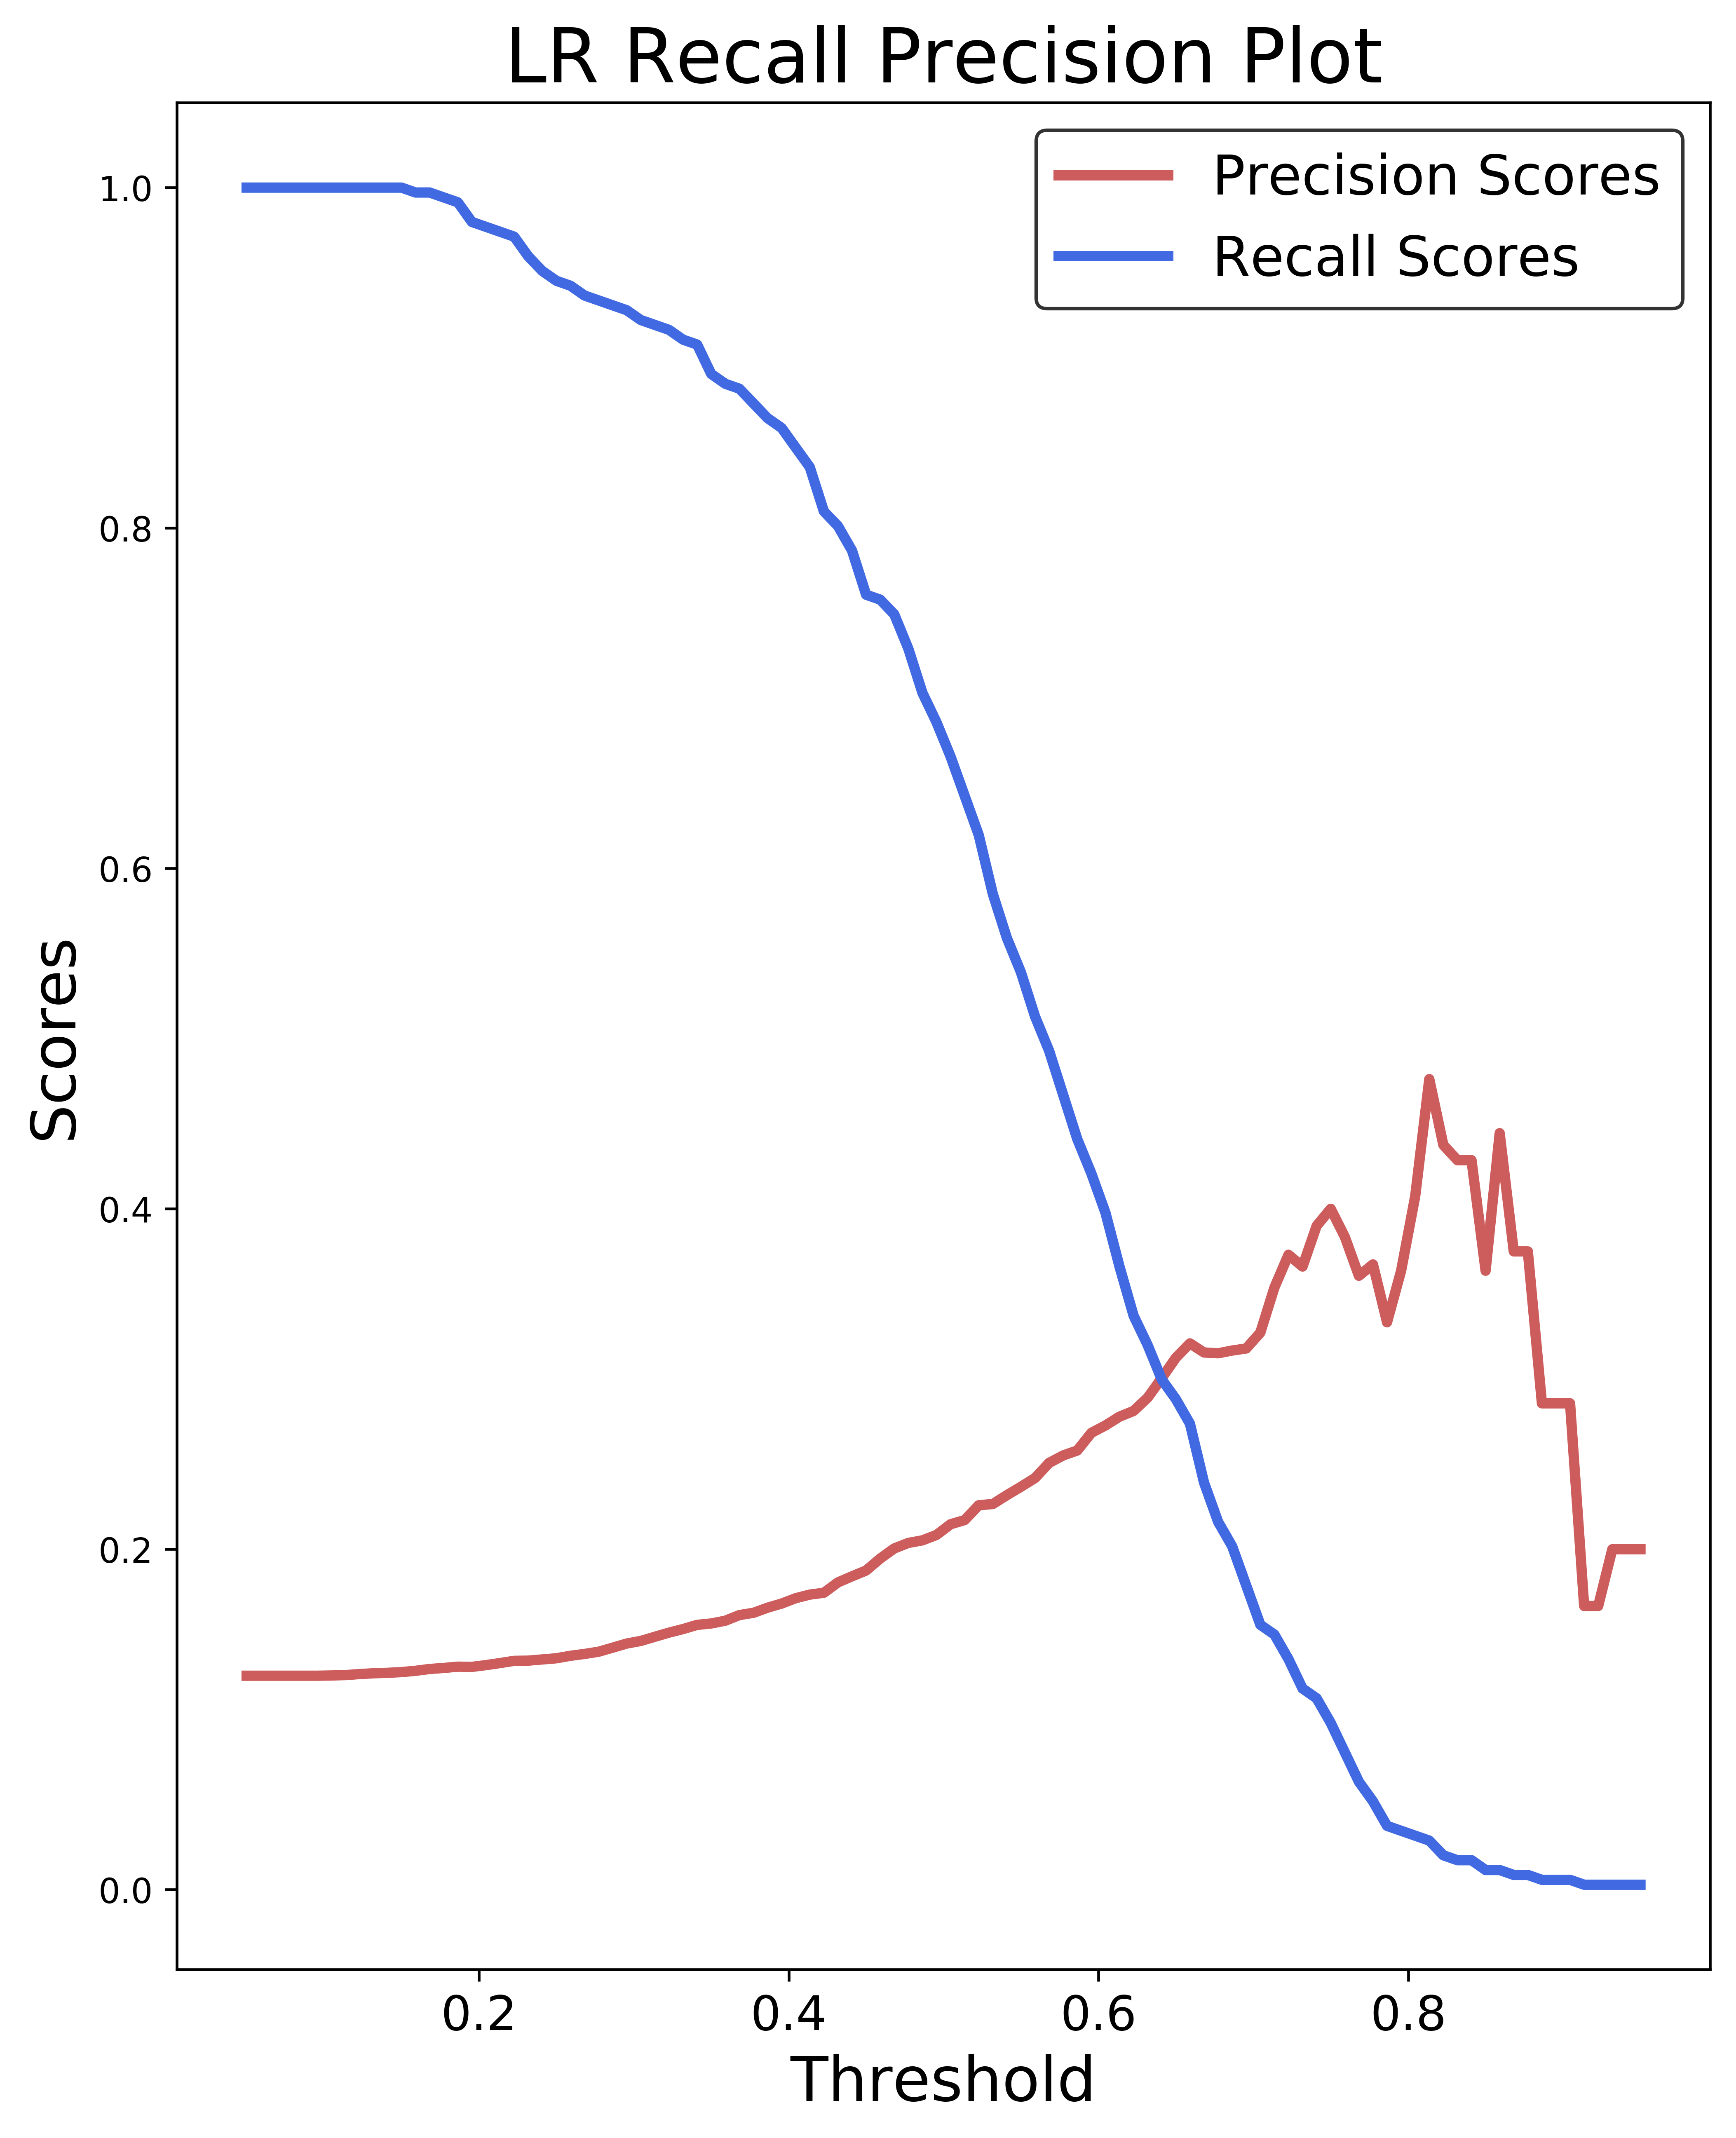

In [48]:
## Investigating the impact of threshold reduction on precision and recall for Logistical Regression
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
# possible thresholds
thresh=np.linspace(0.05,0.95,100)

precisions=[]
recalls=[]
# cycles through the possible thresholds and manually sets the predictions from the predict_proba results
for t in thresh:
    predics=[]
    for i in range(len(lr_predp[:,1])):
        if lr_predp[i,1] > t:
            predics.append(1)
        else:
            predics.append(0)
    #from the manually computed predictions, obtains the precision and recall
    precisions.append(precision_score(y_test,predics))
    recalls.append(recall_score(y_test,predics))
# plotting the results
plt.figure(figsize=(8,10),dpi=600)
plt.plot(thresh,precisions,color='indianred',linewidth=3,label='Precision Scores')
plt.plot(thresh,recalls,color='royalblue',linewidth=3,label='Recall Scores')
plt.title('LR Recall Precision Plot',fontsize=22)
plt.ylabel('Scores',fontsize=18)
plt.xlabel('Threshold',fontsize=18)
plt.xticks(fontsize=14)
plt.legend(edgecolor='black',fontsize=16)
plt.savefig('LR_RP_plot.png')

E:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\Program Files (x86)\Anaconda\lib\site-packages\sklear

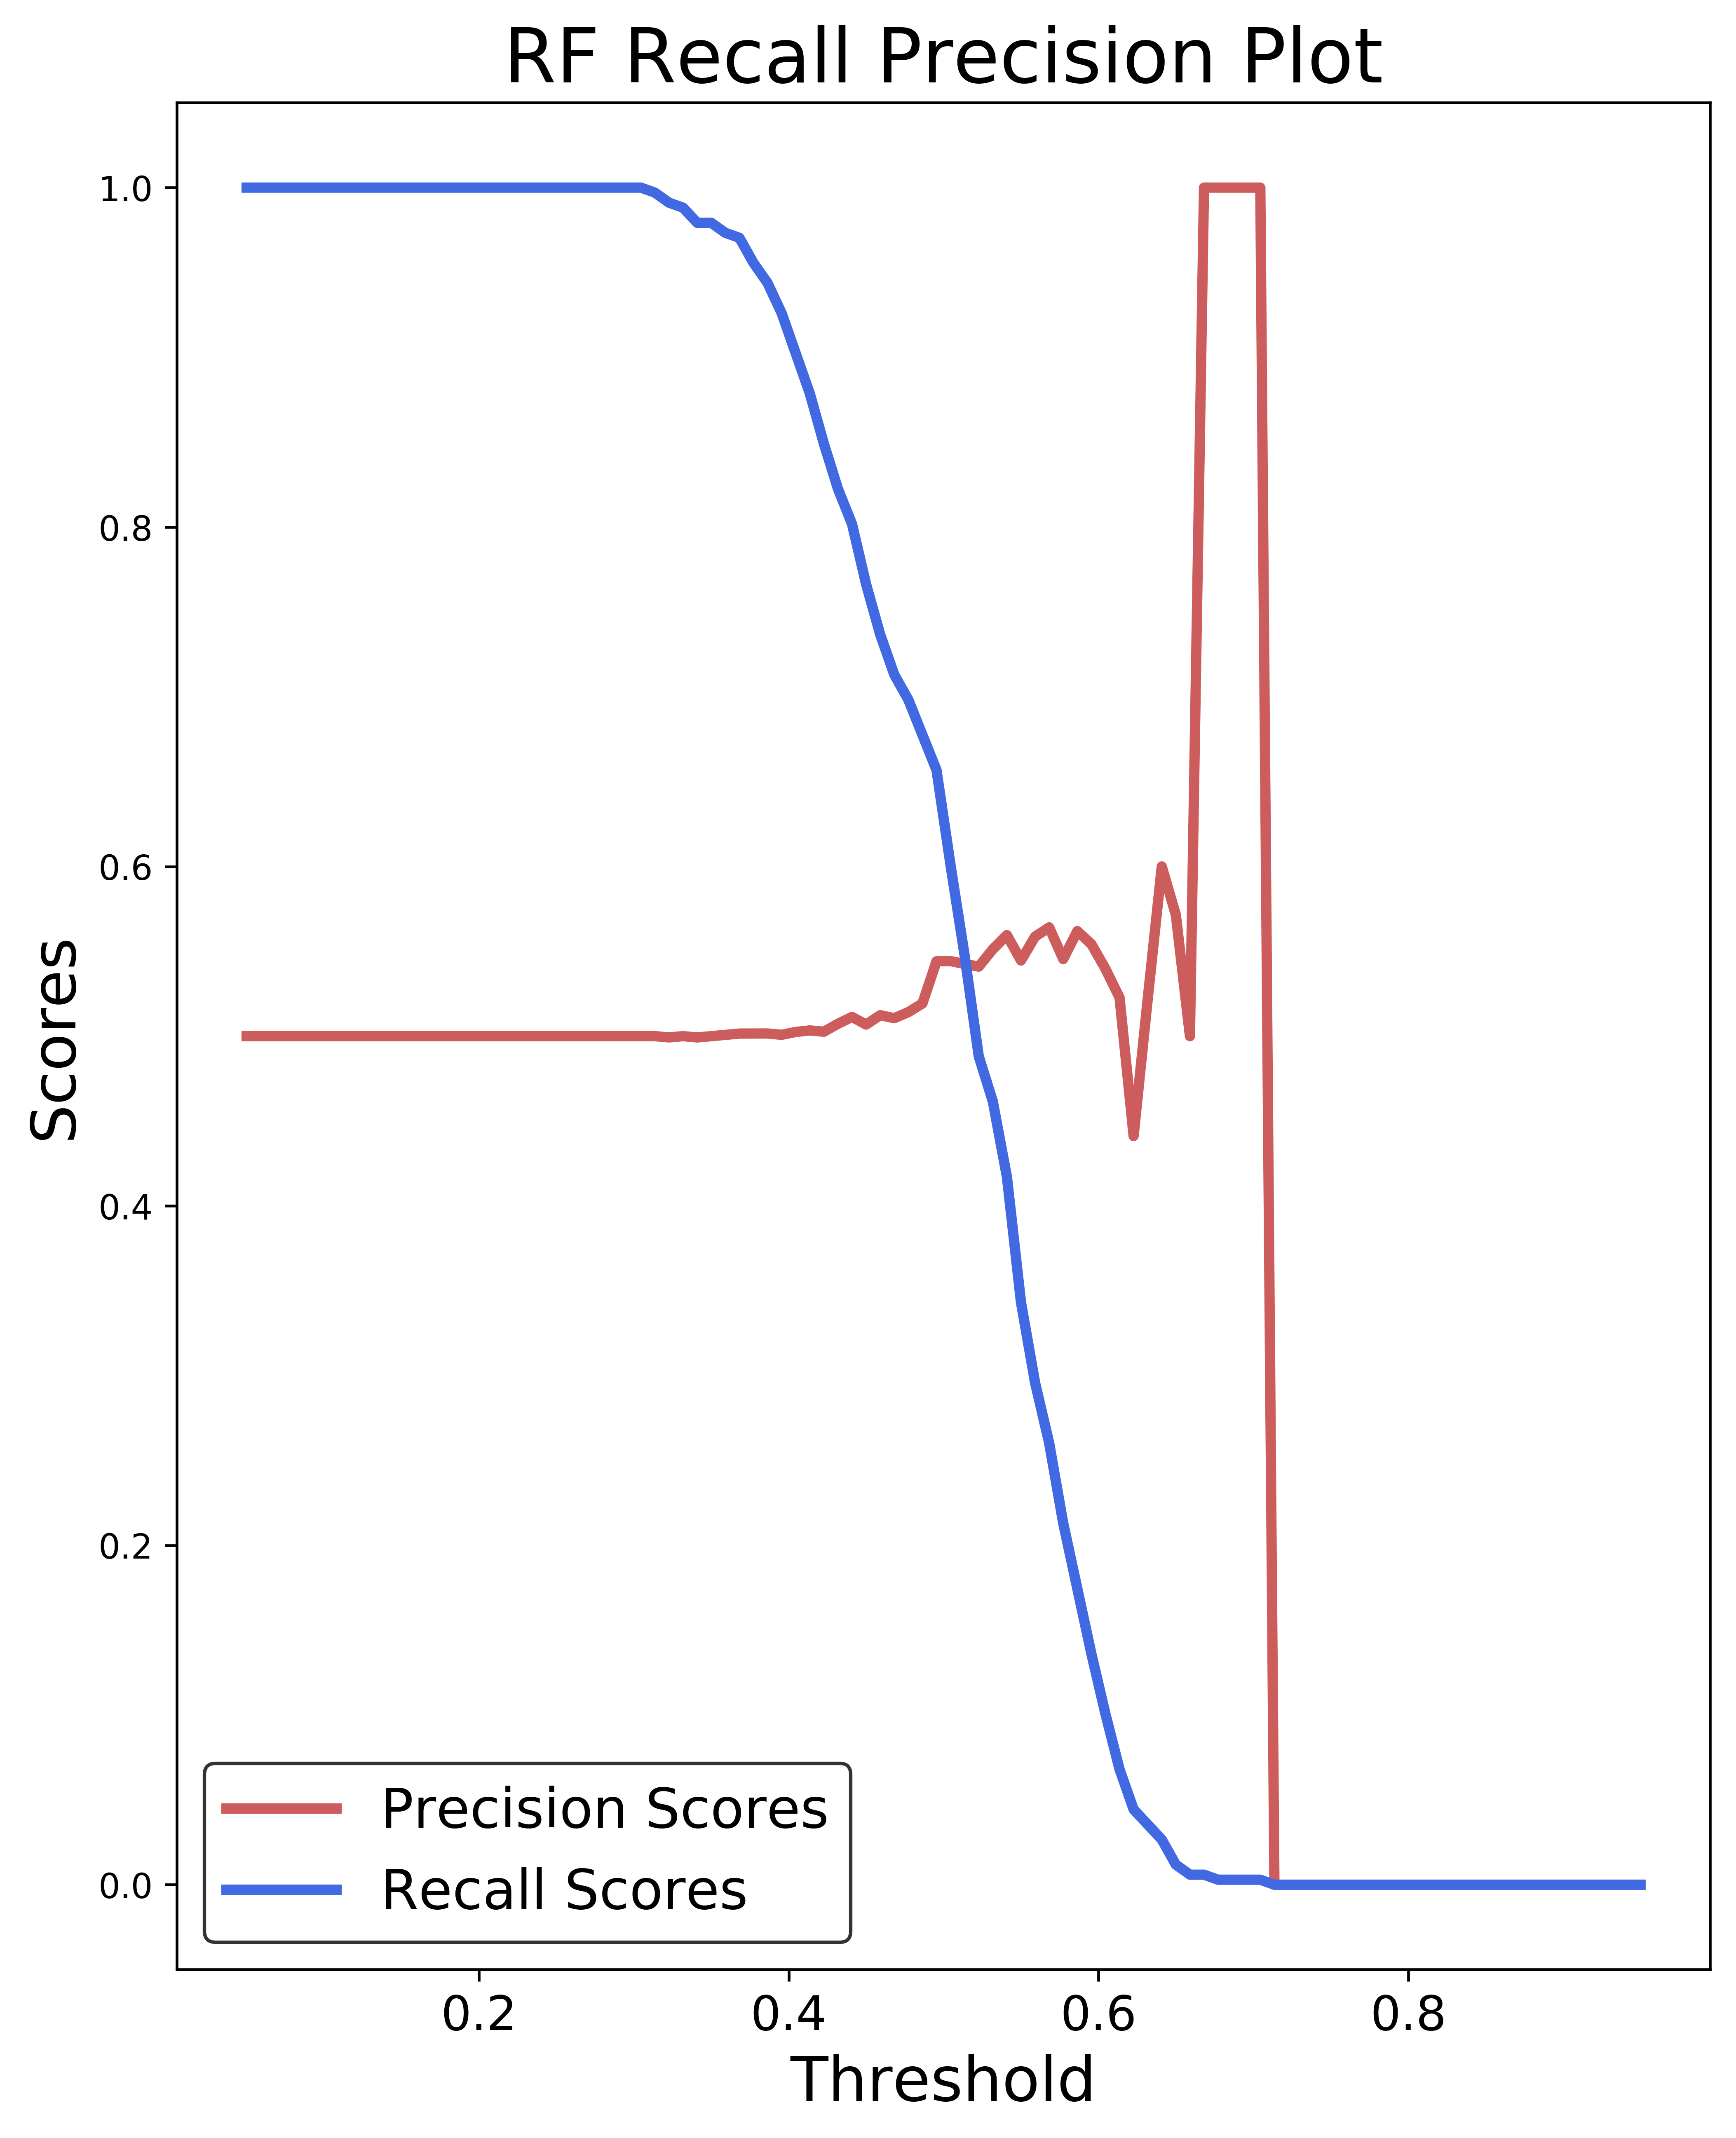

In [49]:
# identical code to above but with the RF model predictions
from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
thresh=np.linspace(0.05,0.95,100)

precisions=[]
recalls=[]
for t in thresh:
    predics=[]
    for i in range(len(rfc_predp[:,1])):
        if rfc_predp[i,1] > t:
            predics.append(1)
        else:
            predics.append(0)
    
    precisions.append(precision_score(y_test_us_str,predics))
    recalls.append(recall_score(y_test_us_str,predics))
plt.figure(figsize=(8,10),dpi=600)
plt.plot(thresh,precisions,color='indianred',linewidth=3,label='Precision Scores')
plt.plot(thresh,recalls,color='royalblue',linewidth=3,label='Recall Scores')
plt.title('RF Recall Precision Plot',fontsize=22)
plt.ylabel('Scores',fontsize=18)
plt.xlabel('Threshold',fontsize=18)
plt.xticks(fontsize=14)
plt.legend(edgecolor='black',fontsize=16)
plt.savefig('RFC_RP_plot.png')

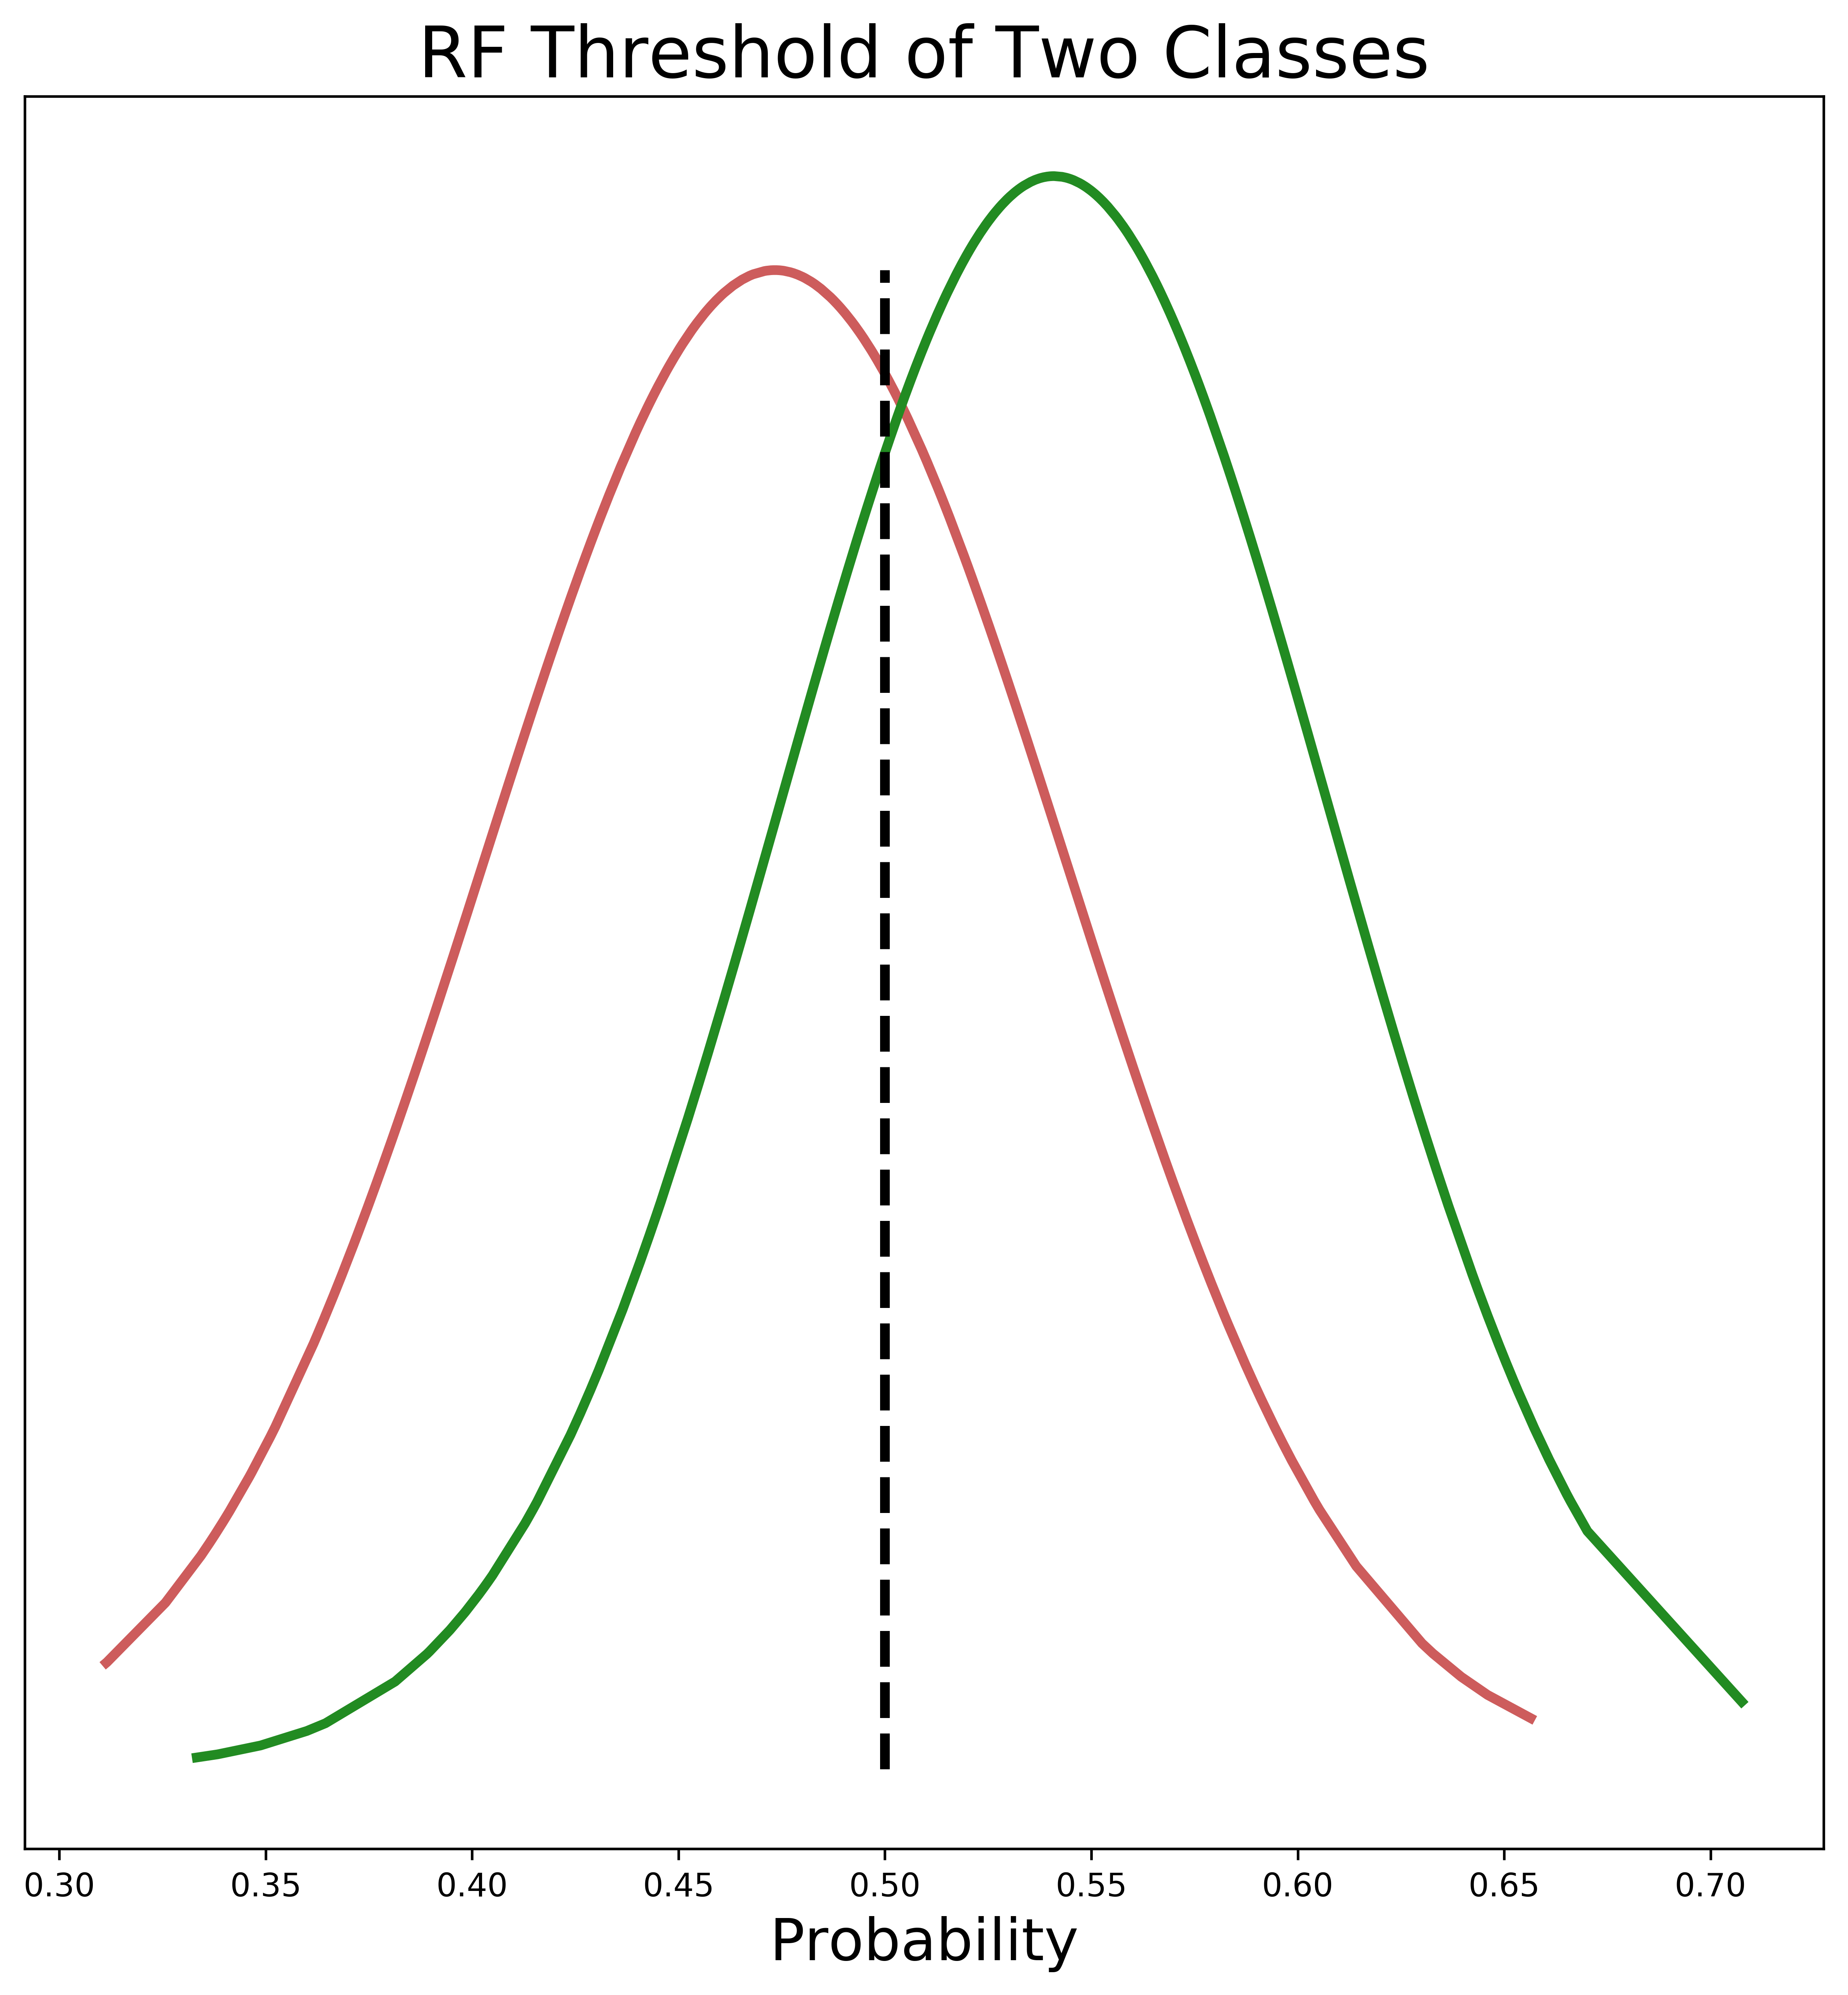

In [8]:
# visualization of the probability distribution functions for the two classes 
# this allows additional visualization of the threshold adjustment impact
import scipy.stats as stats
pos=[]
neg=[]
prob=rfc_predp[:,1]
# cycles through the test Y values to determine if the predicted probability pertains to a negative or positive data point
# appends the predicted probability to the appropriate collection
for i in range(len(prob)):
    if y_test_us_str[i] == 1:
        pos.append(prob[i])
    else:
        neg.append(prob[i])

# sorting of the negative and positive probabilities
neg.sort()
pos.sort()
# obtains the mean for each  distribution
neg_mean = np.mean(neg)
pos_mean = np.mean(pos)
# obtain the std. deviation of each distribution
neg_std = np.std(neg)
pos_std = np.std(pos)
# transforms the data into a normal distribution
negdf = stats.norm.pdf(neg, neg_mean, neg_std)
posdf = stats.norm.pdf(pos, pos_mean, pos_std)

plt.figure(figsize=(10,10),dpi=600)
plt.plot(neg,negdf,color='indianred',linewidth=3,label='Negative Class')
plt.plot(pos,posdf,color='forestgreen',linewidth=3,label='Positive Class')
plt.plot([0.5,0.5],[0,max(negdf)],color='black',linestyle='--',linewidth=3)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelleft=False)
plt.xlabel('Probability',fontsize=18)
plt.title('RF Threshold of Two Classes',fontsize=22)
plt.savefig('RF_Class_Thresholds.png')

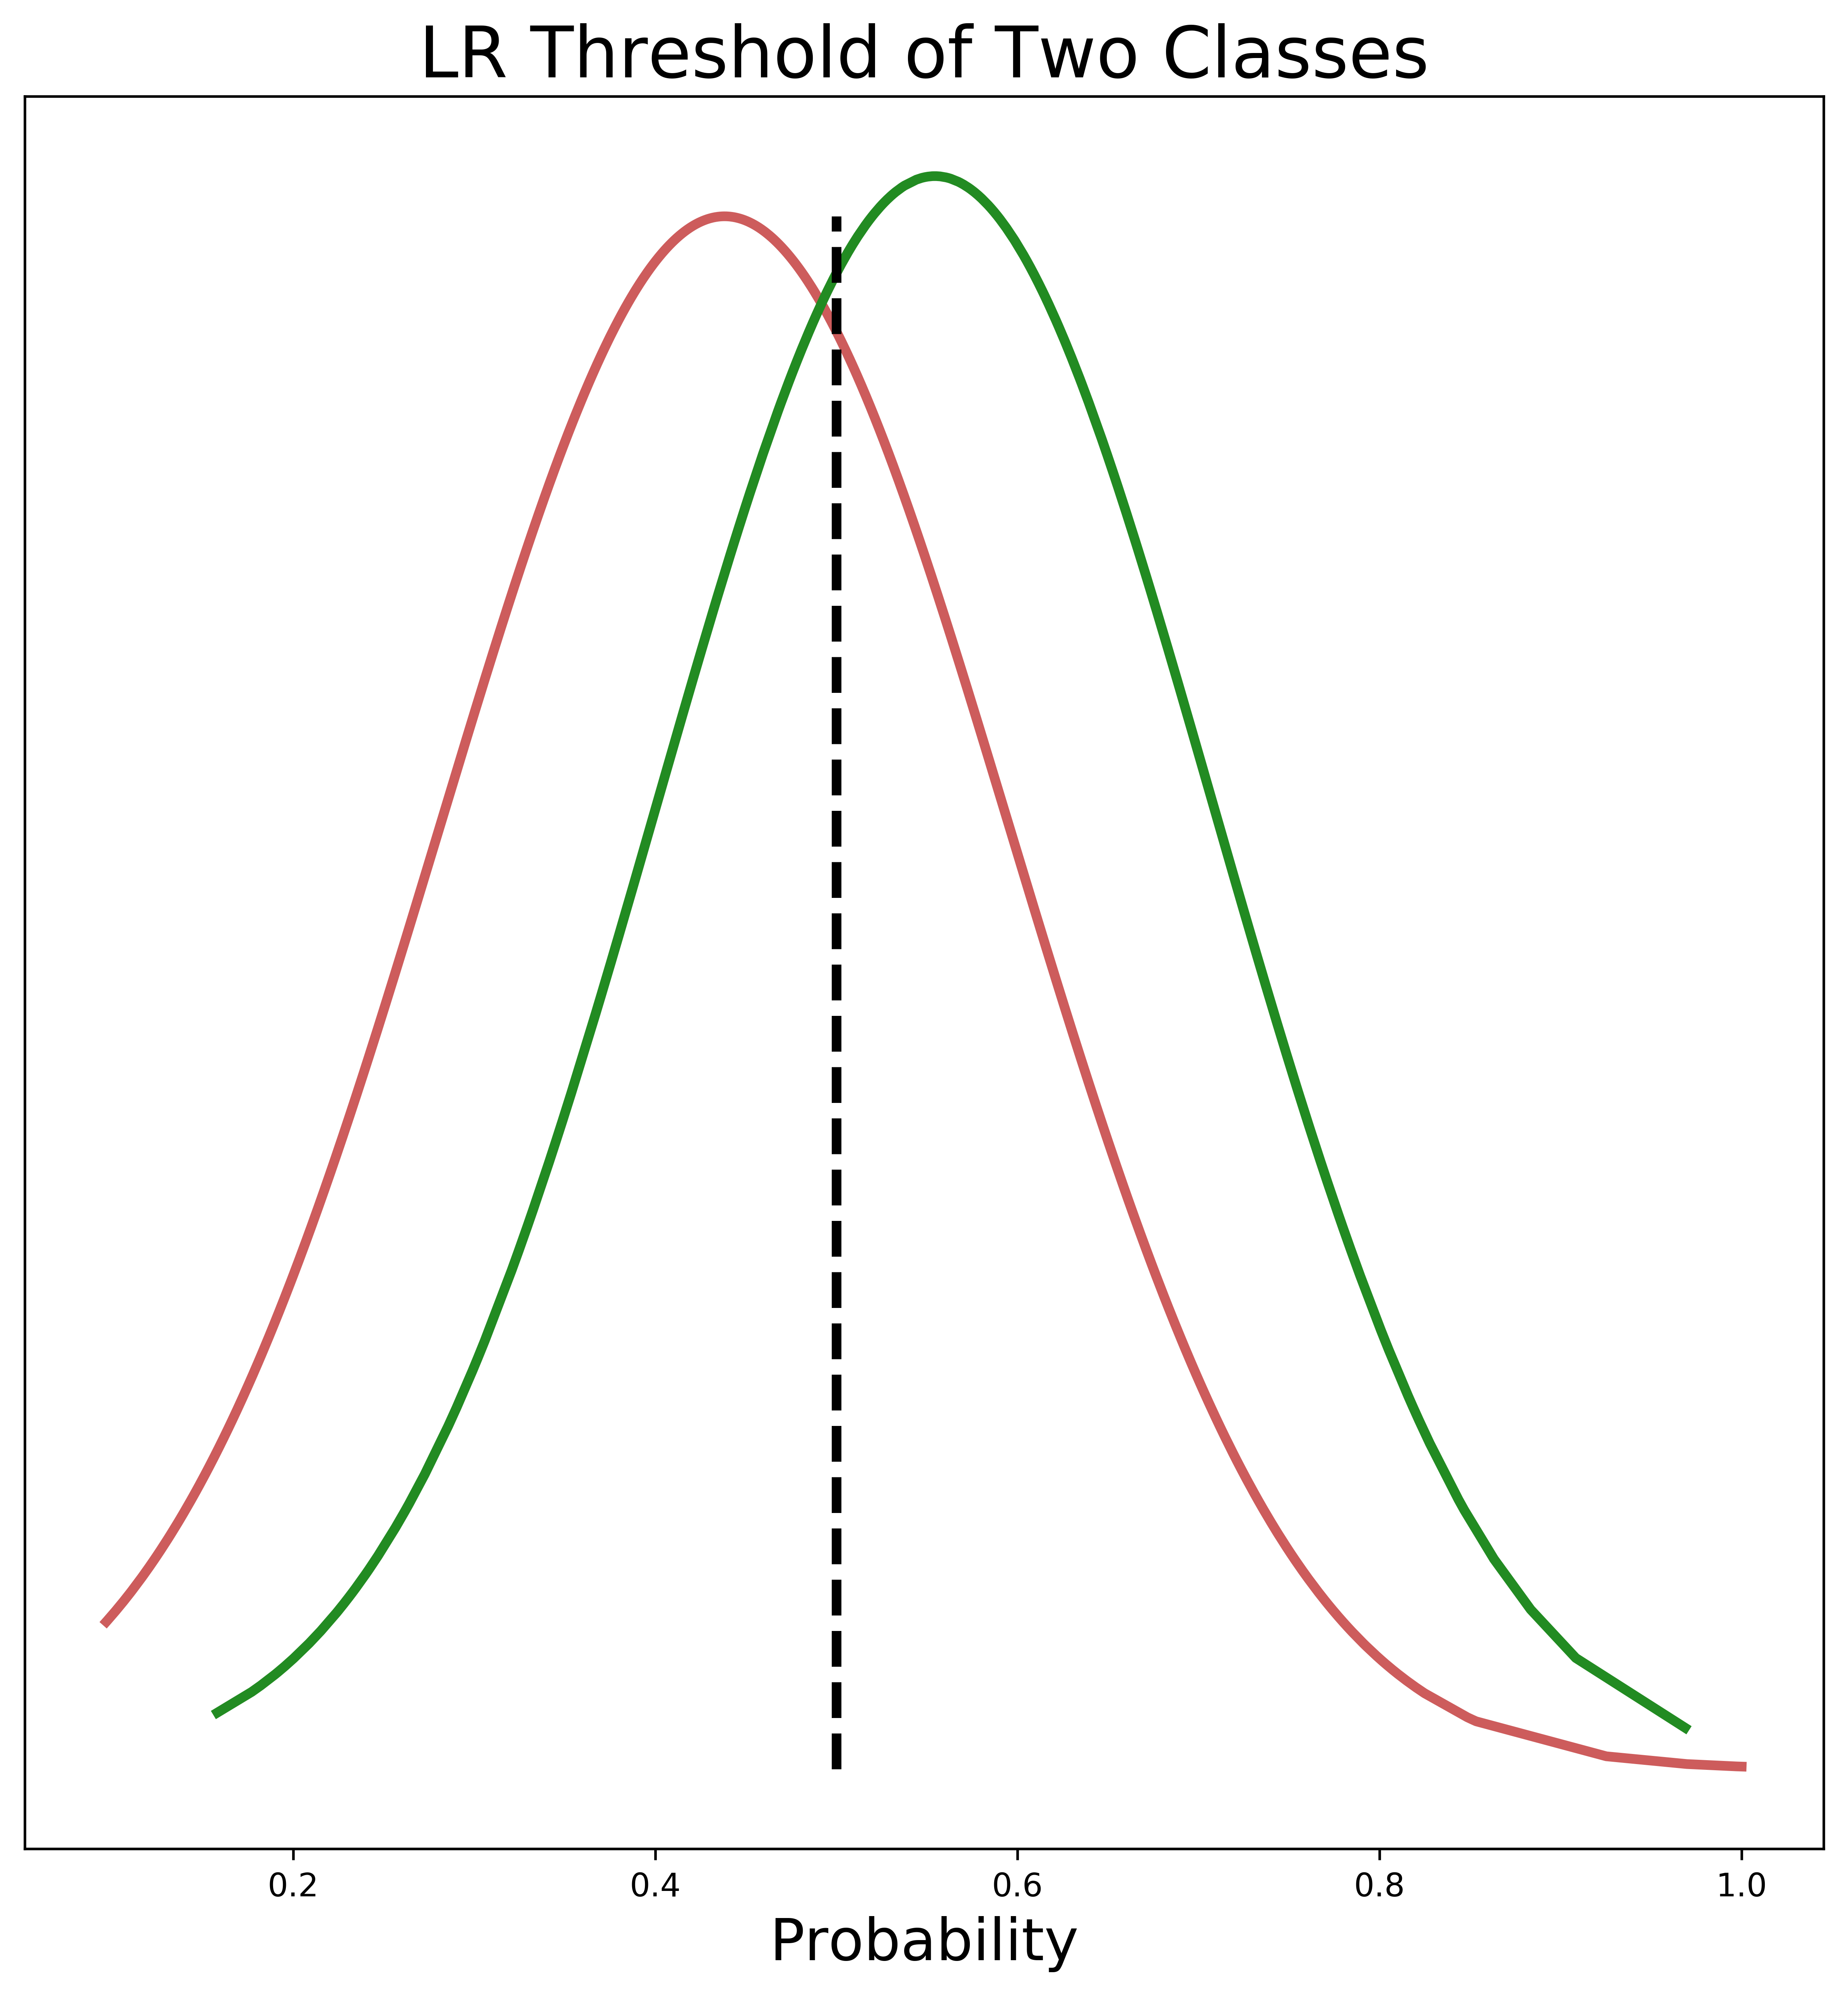

In [20]:
# repeat of the above code segment but for the Logistic regression case
import scipy.stats as stats
pos=[]
neg=[]
prob=lr_predp[:,1]
for i in range(len(prob)):
    if y_test.iloc[i] == 1:
        pos.append(prob[i])
    else:
        neg.append(prob[i])
   
neg.sort()
pos.sort()
neg_mean = np.mean(neg)
pos_mean = np.mean(pos)
neg_std = np.std(neg)
pos_std = np.std(pos)
negdf = stats.norm.pdf(neg, neg_mean, neg_std)
posdf = stats.norm.pdf(pos, pos_mean, pos_std)

plt.figure(figsize=(10,10),dpi=600)
plt.plot(neg,negdf,color='indianred',linewidth=3,label='Negative Class')
plt.plot(pos,posdf,color='forestgreen',linewidth=3,label='Positive Class')
plt.plot([0.5,0.5],[0,max(negdf)],color='black',linestyle='--',linewidth=3)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelleft=False)
plt.xlabel('Probability',fontsize=18)
plt.title('LR Threshold of Two Classes',fontsize=22)
plt.savefig('LR_Class_Thresholds.png')

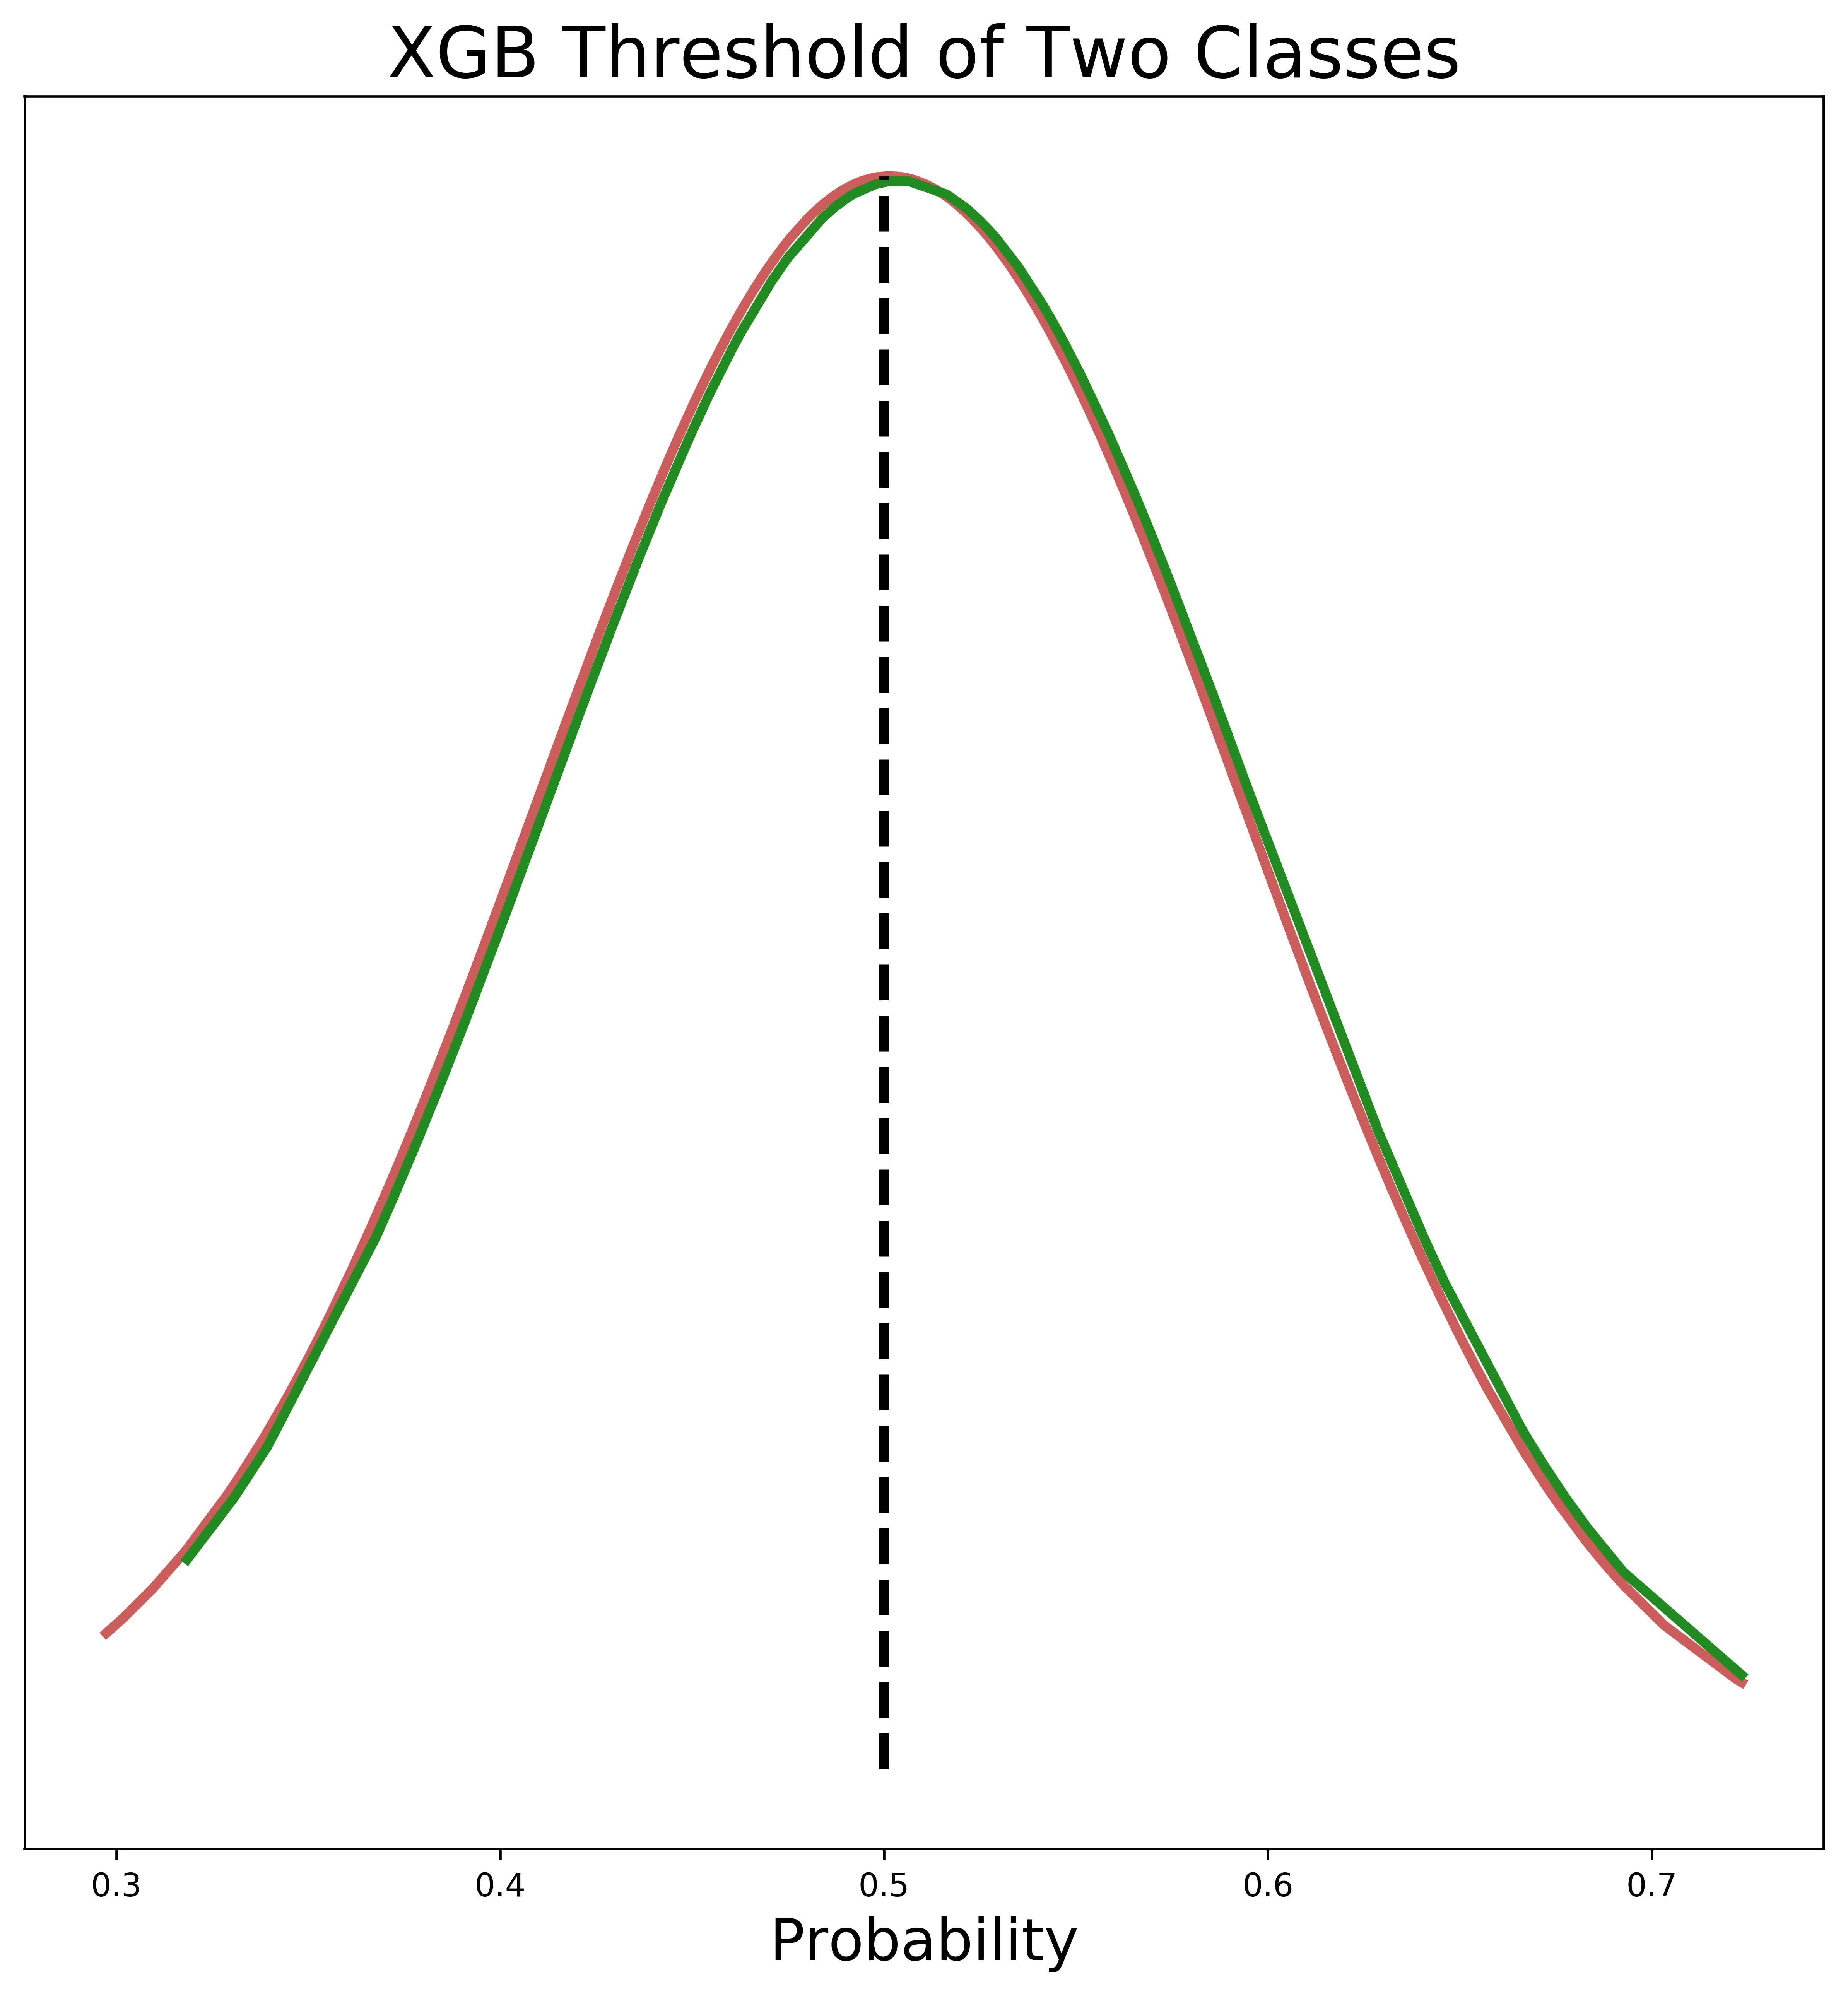

In [28]:
# repeat of the above code but for the xgb case
import scipy.stats as stats
pos=[]
neg=[]
prob=xgb_predp[:,1]
for i in range(len(prob)):
    if y_test.iloc[i] == 1:
        pos.append(prob[i])
    else:
        neg.append(prob[i])
   
neg.sort()
pos.sort()
neg_mean = np.mean(neg)
pos_mean = np.mean(pos)
neg_std = np.std(neg)
pos_std = np.std(pos)
negdf = stats.norm.pdf(neg, neg_mean, neg_std)
posdf = stats.norm.pdf(pos, pos_mean, pos_std)

plt.figure(figsize=(10,10),dpi=600)
plt.plot(neg,negdf,color='indianred',linewidth=3,label='Negative Class')
plt.plot(pos,posdf,color='forestgreen',linewidth=3,label='Positive Class')
plt.plot([0.5,0.5],[0,max(negdf)],color='black',linestyle='--',linewidth=3)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelleft=False)
plt.xlabel('Probability',fontsize=18)
plt.title('XGB Threshold of Two Classes',fontsize=22)
plt.savefig('xgb_Class_Thresholds.png')

In [79]:
# computing the ROC-AUC value for the random forest classifier
y_pred_rfc = rfc.predict_proba(X_test_us_str)[:,1]

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_us_str, y_pred_rfc)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7647841462133679

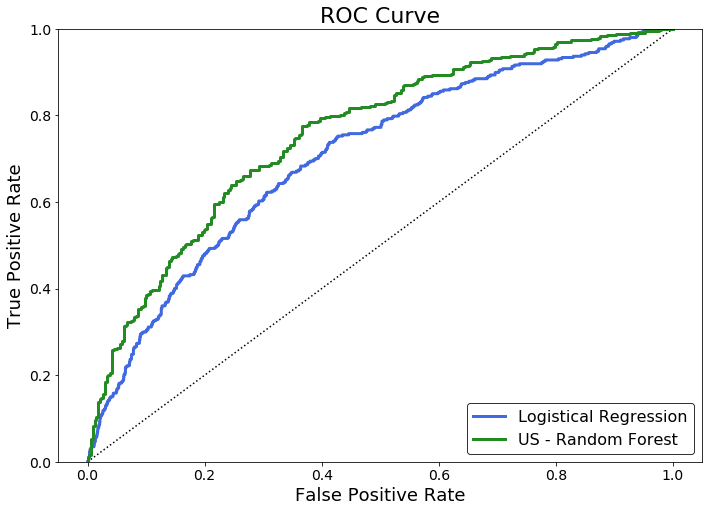

In [135]:
# produces a comparison plot of the ROC curves for the logistic regresssion and randomforest classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
## Plotting ROC Curves

# Create classifiers
lr = LogisticRegression(solver = 'liblinear',C=0.6475,class_weight='balanced',penalty='l1',fit_intercept=True)
rfc = RandomForestClassifier(bootstrap=True,max_depth=5, n_estimators=100, n_jobs=-1)


# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

ax1.plot([0, 1], [0, 1], "k:")

# fitting Logistical Regression then Plotting ROC
lr.fit(X_train,y_train)
lr_y_pred = lr.predict_proba(X_test)[:,1]
lr_fpr, lr_tpr, lr_t = roc_curve(y_test,lr_y_pred)
ax1.plot(lr_fpr, lr_tpr, "-",
         label="%s" % ('Logistical Regression'),linewidth=3,color='royalblue')
# fitting random forest then plotting ROC
rfc.fit(X_train_us_str, y_train_us_str)
rfc_y_pred = rfc.predict_proba(X_test_us_str)[:,1]
rf_fpr, rf_tpr, rf_t = roc_curve(y_test_us_str, rfc_y_pred)
ax1.plot(rf_fpr, rf_tpr, "-",
         label="%s" % ('US - Random Forest'),linewidth=3,color='forestgreen')


ax1.set_ylabel("True Positive Rate",fontsize=18)
ax1.set_xlabel('False Positive Rate',fontsize=18)
ax1.set_ylim([0, 1])
ax1.legend(loc="lower right",fontsize=16,edgecolor='black')
ax1.set_title('ROC Curve',fontsize=22)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlim(0,200)
plt.savefig('ROC_Curves.png')
plt.tight_layout()
plt.show()


In [10]:
# computing the variance and mean distribution of the data used to fit each classifiers
# done using cross validation with 15 stratified folds
from sklearn.model_selection import cross_val_score
lr = LogisticRegression(solver = 'liblinear',C=0.6475,class_weight='balanced',penalty='l1',fit_intercept=True)
rfc = RandomForestClassifier(bootstrap=True,max_depth=5, n_estimators=100, n_jobs=-1)
scores_rf = cross_val_score(rfc,X_res,y_res, cv=15,scoring='recall')
print(scores_rf)
print('Std of Samples: ',np.std(scores_rf))
print('Mean: ', np.mean(scores_rf))

[0.75824176 0.74444444 0.75555556 0.82222222 0.8        0.76666667
 0.68888889 0.65555556 0.6        0.65555556 0.66666667 0.54444444
 0.5        0.52222222 0.46666667]
Std of Samples:  0.11042071389518147
Mean:  0.6631420431420432


In [57]:
# effect of feature reduction on model variation
scores_rf = cross_val_score(rfc,X_res2,y_res2, cv=15,scoring='recall')
print(scores_rf)
print('Std of Samples: ',np.std(scores_rf))
print('Mean: ', np.mean(scores_rf))

[0.82417582 0.78888889 0.82222222 0.81111111 0.75555556 0.73333333
 0.72222222 0.63333333 0.63333333 0.67777778 0.64444444 0.55555556
 0.51111111 0.54444444 0.51111111]
Std of Samples:  0.10858613549228213
Mean:  0.6779080179080179


In [11]:
scores = cross_val_score(lr,data,labels, cv=15,scoring='recall')
print(scores)
print('Std of Samples: ',np.std(scores))
print('Mean: ', np.mean(scores))

[0.9010989  0.8        0.82222222 0.81111111 0.82222222 0.74444444
 0.72222222 0.61111111 0.54444444 0.57777778 0.58888889 0.44444444
 0.44444444 0.43333333 0.35555556]
Std of Samples:  0.1680570317772381
Mean:  0.6415547415547417


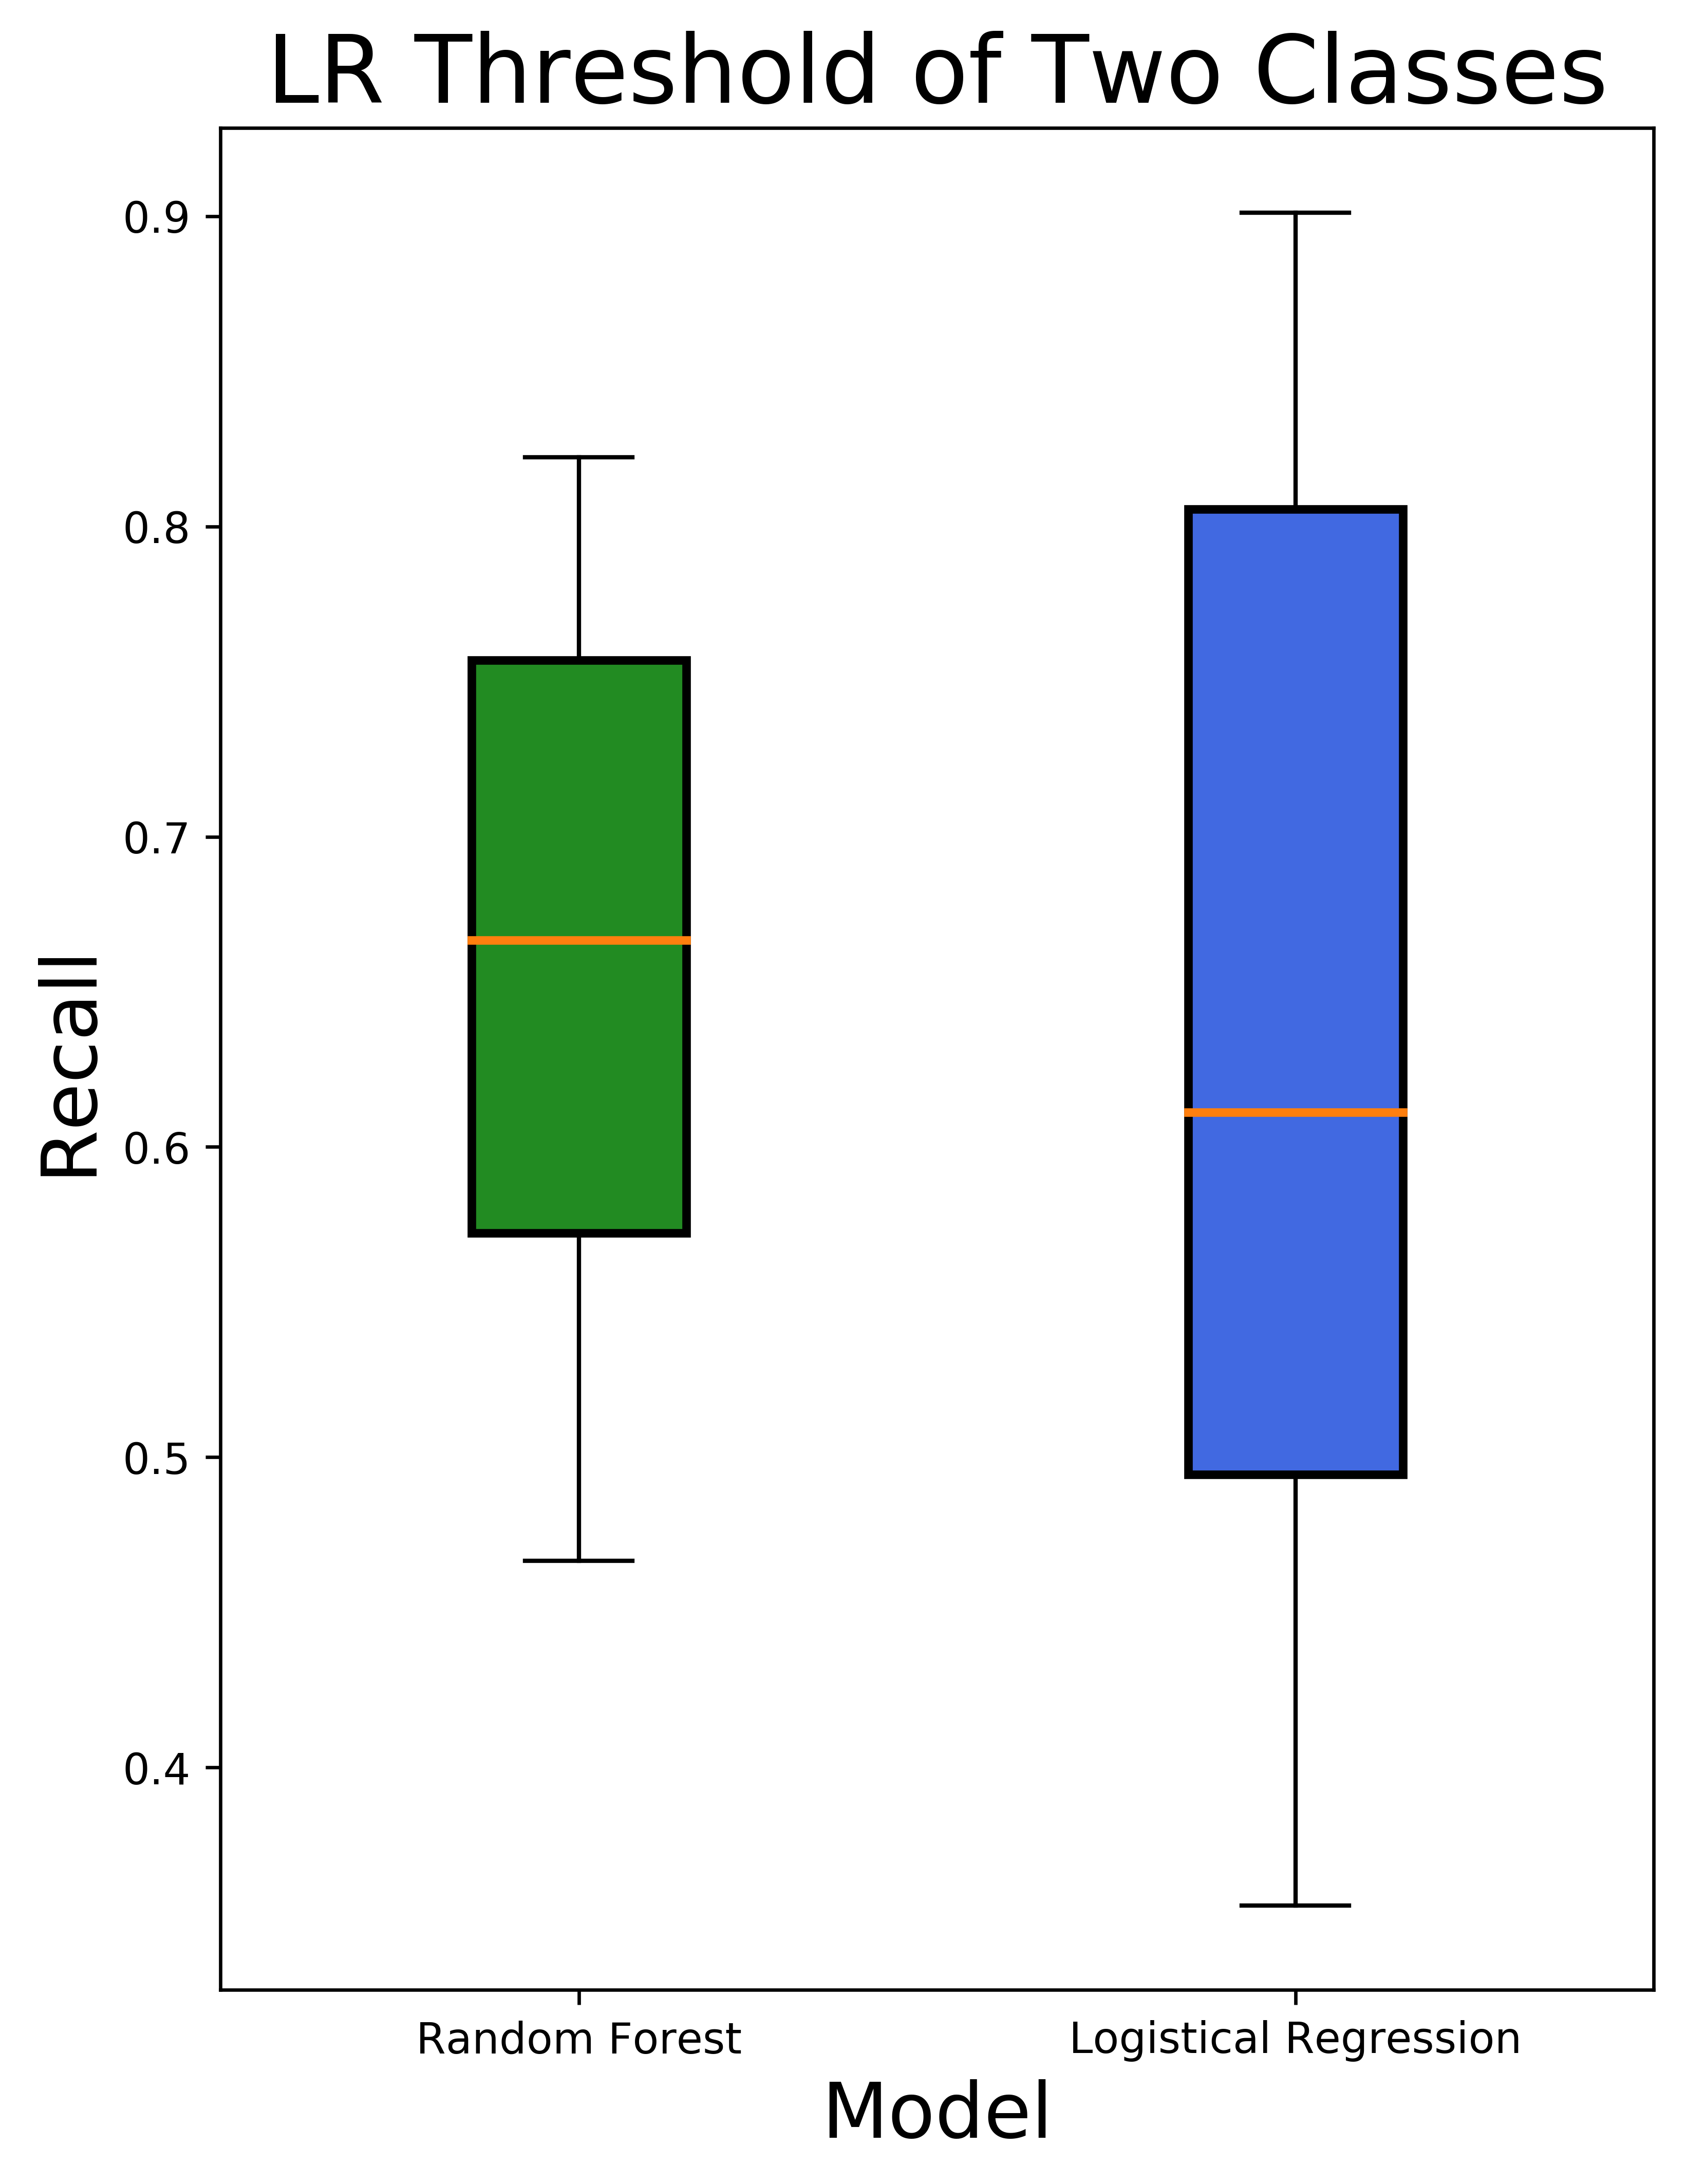

In [12]:
# producing boxplot representations of the variance of each model
import scipy.stats as stats
scores_rf.sort()
scores.sort()
boxprops = dict(linewidth=2,color='o')
medianprops = dict(linewidth=2)

plt.figure(figsize=(6,8),dpi=600)
bp=plt.boxplot([scores_rf,scores],labels=['Random Forest','Logistical Regression'],patch_artist=True
               ,medianprops=medianprops,widths=0.3)
bp['boxes'][0].set_linewidth(2)
bp['boxes'][0].set_facecolor('forestgreen')
bp['boxes'][1].set_linewidth(2)
bp['boxes'][1].set_facecolor('royalblue')

plt.ylabel('Recall',fontsize=18)
plt.xlabel('Model',fontsize=18)
plt.title('LR Threshold of Two Classes',fontsize=22)
plt.savefig('Variance Dists.png')